In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
from sklearn.metrics import pairwise_distances
import math
import dill as pickle


workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.core.utils import get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_eval_indices
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.voxel.crossvalidation import CrossvalNW

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#read data
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
major_structure_ids = np.load(workingdirectory + '/data/meta/major_structure_ids.npy')
data_info = pd.read_excel(workingdirectory + '/data/meta/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
folder =  '/Users/samsonkoelle/mouse_connectivity_models/data/raw/'

annotation/ccf_2017


In [5]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False, structure_set_id=167587189, folder = folder)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [7]:
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
ontological_order = np.load('data/meta/ontological_order_v3.npy')

ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]

targ_ord = ontological_order_leaves
source_ord = ontological_order_leaves
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=targ_ord, hemisphere_id=2)
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)


In [8]:

gammas = np.asarray([0.0001,0.001,0.01,0.1,1,10,100,1000,10000])
reg_proj_injnorm = {sid: connectivity_data.structure_datas[sid].reg_proj_injnorm for sid in major_structure_ids}
crelines = {sid: connectivity_data.creline[sid] for sid in major_structure_ids}
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.get_creleaf_combos()
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)
connectivity_data.cre2_index_matrices = get_indices_2ormore(crelines)
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)
creleaf2_evalindices = {sid: connectivity_data.creleaf2_evalindices[sid] for sid in major_structure_ids} 
cre2_index_matrices = {sid: connectivity_data.cre2_index_matrices[sid] for sid in major_structure_ids} 
connectivity_data.major2_index_matrices = {}
for sid in major_structure_ids:
     connectivity_data.major2_index_matrices[sid] =  np.expand_dims(np.ones(crelines[sid].shape),0)
major2_index_matrices = {sid:connectivity_data.major2_index_matrices[sid] for sid in major_structure_ids}

wtmajor2_index_matrices = {}
for sid in major_structure_ids:
    wtm = np.zeros(major2_index_matrices[sid].shape) 
    wtmajor2_index_matrices[sid] = wtm[:,np.where(crelines[sid] == 'C57BL/6J')[0]] = 1

ncreleaf2 = np.zeros(12)
ntotal = np.zeros(12)
for i in range(12):
    sid = major_structure_ids[i]
    ntotal[i] = connectivity_data.structure_datas[sid].reg_proj.shape[0]
    ncreleaf2[i] = len(creleaf2_evalindices[sid])

major_structures = np.asarray(major_structures)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0], dtype = int)
df = pd.DataFrame([ntotal,  ncreleaf2], dtype = int, index=['Total','Cre-Leaf'], columns = major_structures[reo]).transpose()
#df = pd.DataFrame([ntotal, ncresum2, ncresum2_leaf2,  ncreleaf2], dtype = int, index=['Total','Cre-Summary','Cre-Summary, Leaf','Cre-Leaf']).transpose()
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Total &  Cre-Leaf \\
\midrule
Isocortex &     36 &         4 \\
OLF       &      7 &         2 \\
HPF       &    122 &        62 \\
CTXsp     &     85 &        41 \\
STR       &   1128 &       732 \\
PAL       &     68 &        18 \\
TH        &     46 &         7 \\
HY        &     35 &        17 \\
MB        &     33 &         8 \\
P         &     30 &        11 \\
MY        &     78 &        45 \\
CB        &     83 &        29 \\
\bottomrule
\end{tabular}



In [16]:
nw_major_creleaf2.meanloss_weighted

array([0.11208504, 0.62132425, 0.22802745, 0.31702127, 0.27481252,
       0.20204002, 0.18937253, 0.17988295, 0.29906091, 0.29177467,
       0.23227839, 0.37938673])

In [10]:
frac_learn = np.ones(12)
for m in range(12):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_leaf = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])
    connectivity_data.structure_datas[sid].smoothed_losses_leaf = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_leaf,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_leaf.cre_distances_cv)
    

/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:47: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.norm(coordinates, axis=0)  # **2
/Users/s

In [11]:
reg_proj_norm = {sid: connectivity_data.structure_datas[sid].reg_proj_norm for sid in major_structure_ids}
creleaf2_index_matrices = {sid: connectivity_data.creleaf2_index_matrices[sid] for sid in major_structure_ids} 
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
distances = pds

In [ ]:
nw_creleaf_creleaf2 = CrossvalNW(reg_proj_norm, distances,creleaf2_index_matrices, creleaf2_evalindices,gammas)
nw_creleaf_creleaf2.gammas = gammas
nw_creleaf_creleaf2.predictions = nw_creleaf_creleaf2.get_predictions()
nw_creleaf_creleaf2.get_results_loocv()
nw_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [10]:
nw_leaf_creleaf2 = CrossvalNW(reg_proj_norm, distances,leaf2_index_matrices, creleaf2_evalindices,gammas)
nw_leaf_creleaf2.gammas = gammas# ds
nw_leaf_creleaf2.predictions = nw_leaf_creleaf2.get_predictions()
nw_leaf_creleaf2.get_results_loocv()
nw_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)



/Users/samsonkoelle/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:43: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


In [11]:
nw_leaf_creleaf2.meanloss_weighted

array([0.06789274, 0.75822031, 0.20116005, 0.3595262 , 0.35816521,
       0.27667408, 0.18858372, 0.13179941, 0.40423838, 0.33989079,
       0.17371725, 0.36240886])

In [14]:
nw_leaf_creleaf2.meanloss_weighted

array([0.06789274, 0.75822031, 0.20116005, 0.3595262 , 0.35816521,
       0.27667408, 0.18858372, 0.13179941, 0.40423838, 0.33989079,
       0.17371725, 0.36240886])

In [10]:

#distances = pds#{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_cremajor_creleaf2 = CrossvalNW(reg_proj_norm, distances,cre2_index_matrices, creleaf2_evalindices,gammas)
nw_cremajor_creleaf2.gammas = gammas# ds
nw_cremajor_creleaf2.predictions = nw_cremajor_creleaf2.get_predictions()
nw_cremajor_creleaf2.get_results_loocv()
nw_cremajor_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

mean_gammas = np.ones(12)*0.000001
mean_creleaf_creleaf2 = CrossvalNW(reg_proj_norm, distances, creleaf2_index_matrices, creleaf2_evalindices,mean_gammas)
mean_creleaf_creleaf2.gammas = mean_gammas# ds
mean_creleaf_creleaf2.predictions = mean_creleaf_creleaf2.get_predictions()
mean_creleaf_creleaf2.get_results_loocv()
mean_creleaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


In [15]:

##{sid: connectivity_data.structure_datas[sid].smoothed_losses_str for sid in major_structure_ids}
nw_major_creleaf2 = CrossvalNW(reg_proj_norm, distances,major2_index_matrices, creleaf2_evalindices,gammas)
nw_major_creleaf2.gammas = gammas
nw_major_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_major_creleaf2.get_results_loocv()
nw_major_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


In [16]:
nw_major_creleaf2.meanloss_weighted

array([0.11167395, 0.75822031, 0.23583601, 0.33894674, 0.3701782 ,
       0.28503981, 0.18796564, 0.1753131 , 0.40245081, 0.32411597,
       0.23670777, 0.36011381])

In [11]:


nw_majorwt_creleaf2 = CrossvalNW(reg_proj_norm, distances,wtmajor2_index_matrices, creleaf2_evalindices,gammas)
nw_majorwt_creleaf2.gammas = gammas
nw_majorwt_creleaf2.predictions = nw_major_creleaf2.get_predictions()
nw_majorwt_creleaf2.get_results_loocv()
nw_majorwt_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)


# nw_sum_cresum2leaf2 = CrossvalNW(reg_proj_norm, distances,sum2_index_matrices, cresum2_leaf2_evalindices,gammas)
# nw_sum_cresum2leaf2.gammas = gammas
# nw_sum_cresum2leaf2.predictions = nw_sum_cresum2leaf2.get_predictions()
# nw_sum_cresum2leaf2.get_results_loocv()
# nw_sum_cresum2leaf2.get_results_weightedloocv(connectivity_data.summary_structures,crelines,ia_map)
#nw_sum_creleaf2.meanloss

In [8]:
leaf2_index_matrices = {sid: connectivity_data.leaf2_index_matrices[sid] for sid in major_structure_ids} 
distances = {sid: connectivity_data.structure_datas[sid].smoothed_losses_leaf for sid in major_structure_ids}
twostage_leaf_creleaf2 = CrossvalNW(reg_proj_norm, distances, leaf2_index_matrices, creleaf2_evalindices,gammas)
twostage_leaf_creleaf2.gammas = gammas #ds
twostage_leaf_creleaf2.predictions = twostage_leaf_creleaf2.get_predictions()
twostage_leaf_creleaf2.get_results_loocv()
twostage_leaf_creleaf2.get_results_weightedloocv(connectivity_data.leafs,crelines,ia_map)

In [13]:
#el_labels = np.zeros(150, dtype = str)
models = np.asarray(['Mean','NW','NW','NW','NW','NW','EL'])
datas = np.asarray([r"$I_c \cap I_L$",
                   r"$I_c \cap I_M$",
                   r"$I_c \cap I_L$",
                    r"$I_L$",
                  r"$I_{wt} \cap I_M$",
                  r"$I_M$"  ,
                  r"$I_L$"])
multi_ind = np.vstack([models,datas])
multi_ind = np.asarray(multi_ind, dtype = str)
multi_ind = list(zip(*multi_ind))
multi_ind = pd.MultiIndex.from_tuples(multi_ind, names=[r"$\widehat f$",r"$\mathcal D$"])

reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
results = pd.DataFrame([mean_creleaf_creleaf2.meanloss_weighted,
nw_cremajor_creleaf2.meanloss_weighted,
nw_creleaf_creleaf2.meanloss_weighted,
nw_leaf_creleaf2.meanloss_weighted,
nw_majorwt_creleaf2.meanloss_weighted,
nw_major_creleaf2.meanloss_weighted,
twostage_leaf_creleaf2.meanloss_weighted], index = multi_ind, columns = major_structures).transpose()#, cre2_index_matrices
trunc = lambda x: math.trunc(1000 * x) / 1000;

results = results.applymap(trunc)

In [14]:
print(results.iloc[reo].to_latex(index=True,escape=False))

\begin{tabular}{lrrrrrrr}
\toprule
$\widehat f$ &           Mean & \multicolumn{5}{l}{NW} &     EL \\
$\mathcal D$ & $I_c \cap I_L$ & $I_c \cap I_M$ & $I_c \cap I_L$ &  $I_L$ & $I_{wt} \cap I_M$ &  $I_M$ &  $I_L$ \\
\midrule
Isocortex &          0.239 &          0.252 &          0.234 &  0.279 &             0.274 &  0.274 &  0.228 \\
OLF       &          0.193 &          0.233 &          0.191 &  0.135 &             0.179 &  0.179 &  0.138 \\
HPF       &          0.175 &          0.332 &          0.170 &  0.205 &             0.228 &  0.228 &  0.153 \\
CTXsp     &          0.621 &          0.621 &          0.621 &  0.621 &             0.621 &  0.621 &  0.621 \\
STR       &          0.131 &          0.121 &          0.128 &  0.169 &             0.232 &  0.232 &  0.124 \\
PAL       &          0.203 &          0.205 &          0.203 &  0.295 &             0.291 &  0.291 &  0.188 \\
TH        &          0.673 &          0.664 &          0.673 &  0.358 &             0.379 &  0.379 &  0.369 \

In [15]:
nw_cremajor_creleaf2.meanloss_weighted

array([0.06210006, 0.62132425, 0.33264995, 0.38295036, 0.25281674,
       0.19182479, 0.3476429 , 0.23378519, 0.29210903, 0.20522458,
       0.12117065, 0.66476902])

In [97]:
fontsizes = {}
fontsizes[512] = 50
fontsizes[703] = 50
fontsizes[1089] = 50
fontsizes[1097] = 50
fontsizes[315] = 20
fontsizes[313] = 50
fontsizes[354] = 50
fontsizes[698] = 50
fontsizes[771] = 50
fontsizes[803] = 50
fontsizes[477] = 50
fontsizes[549] = 50

In [70]:
def plot_loss(meanloss, fontsize):
    ydim = meanloss.shape[0]
    ticks=np.arange(np.nanmin(meanloss),np.nanmax(meanloss))
    fig = plt.figure(figsize=(60,40))
    ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
    ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
    ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

    mask = np.zeros_like(meanloss)
    mask[np.tril_indices_from(mask)] = True

    sns.heatmap(meanloss, ax = ax1, annot=False, cmap="Greys", linecolor='b', cbar = False,annot_kws={"size": 20})
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(meanloss.columns,rotation=40, fontsize = 40)
    ax1.set_yticklabels(meanloss.index,rotation=40, fontsize = 40)
    sns.heatmap((pd.DataFrame(meanloss.mean(axis=0))).transpose(), ax=ax2,  annot=False,annot_kws={"size": 20}, cmap="Greys", cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(pd.DataFrame(meanloss.mean(axis=1)), ax=ax3,  cbar_kws={"fraction":.7, "pad":-.1},annot=False, cmap="Greys",annot_kws={"size": 20}, cbar=True, xticklabels=False, yticklabels=False)
    #ax2hm.cbar.set
    cbar = ax3.collections[0].colorbar
    cbar.ax.tick_params(labelsize=70)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = fontsize, rotation = 90)
    
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = fontsize, rotation = 0)
    return(fig)

In [71]:
# import matplotlib as mpl
# help(mpl.figure.Figure.colorbar)

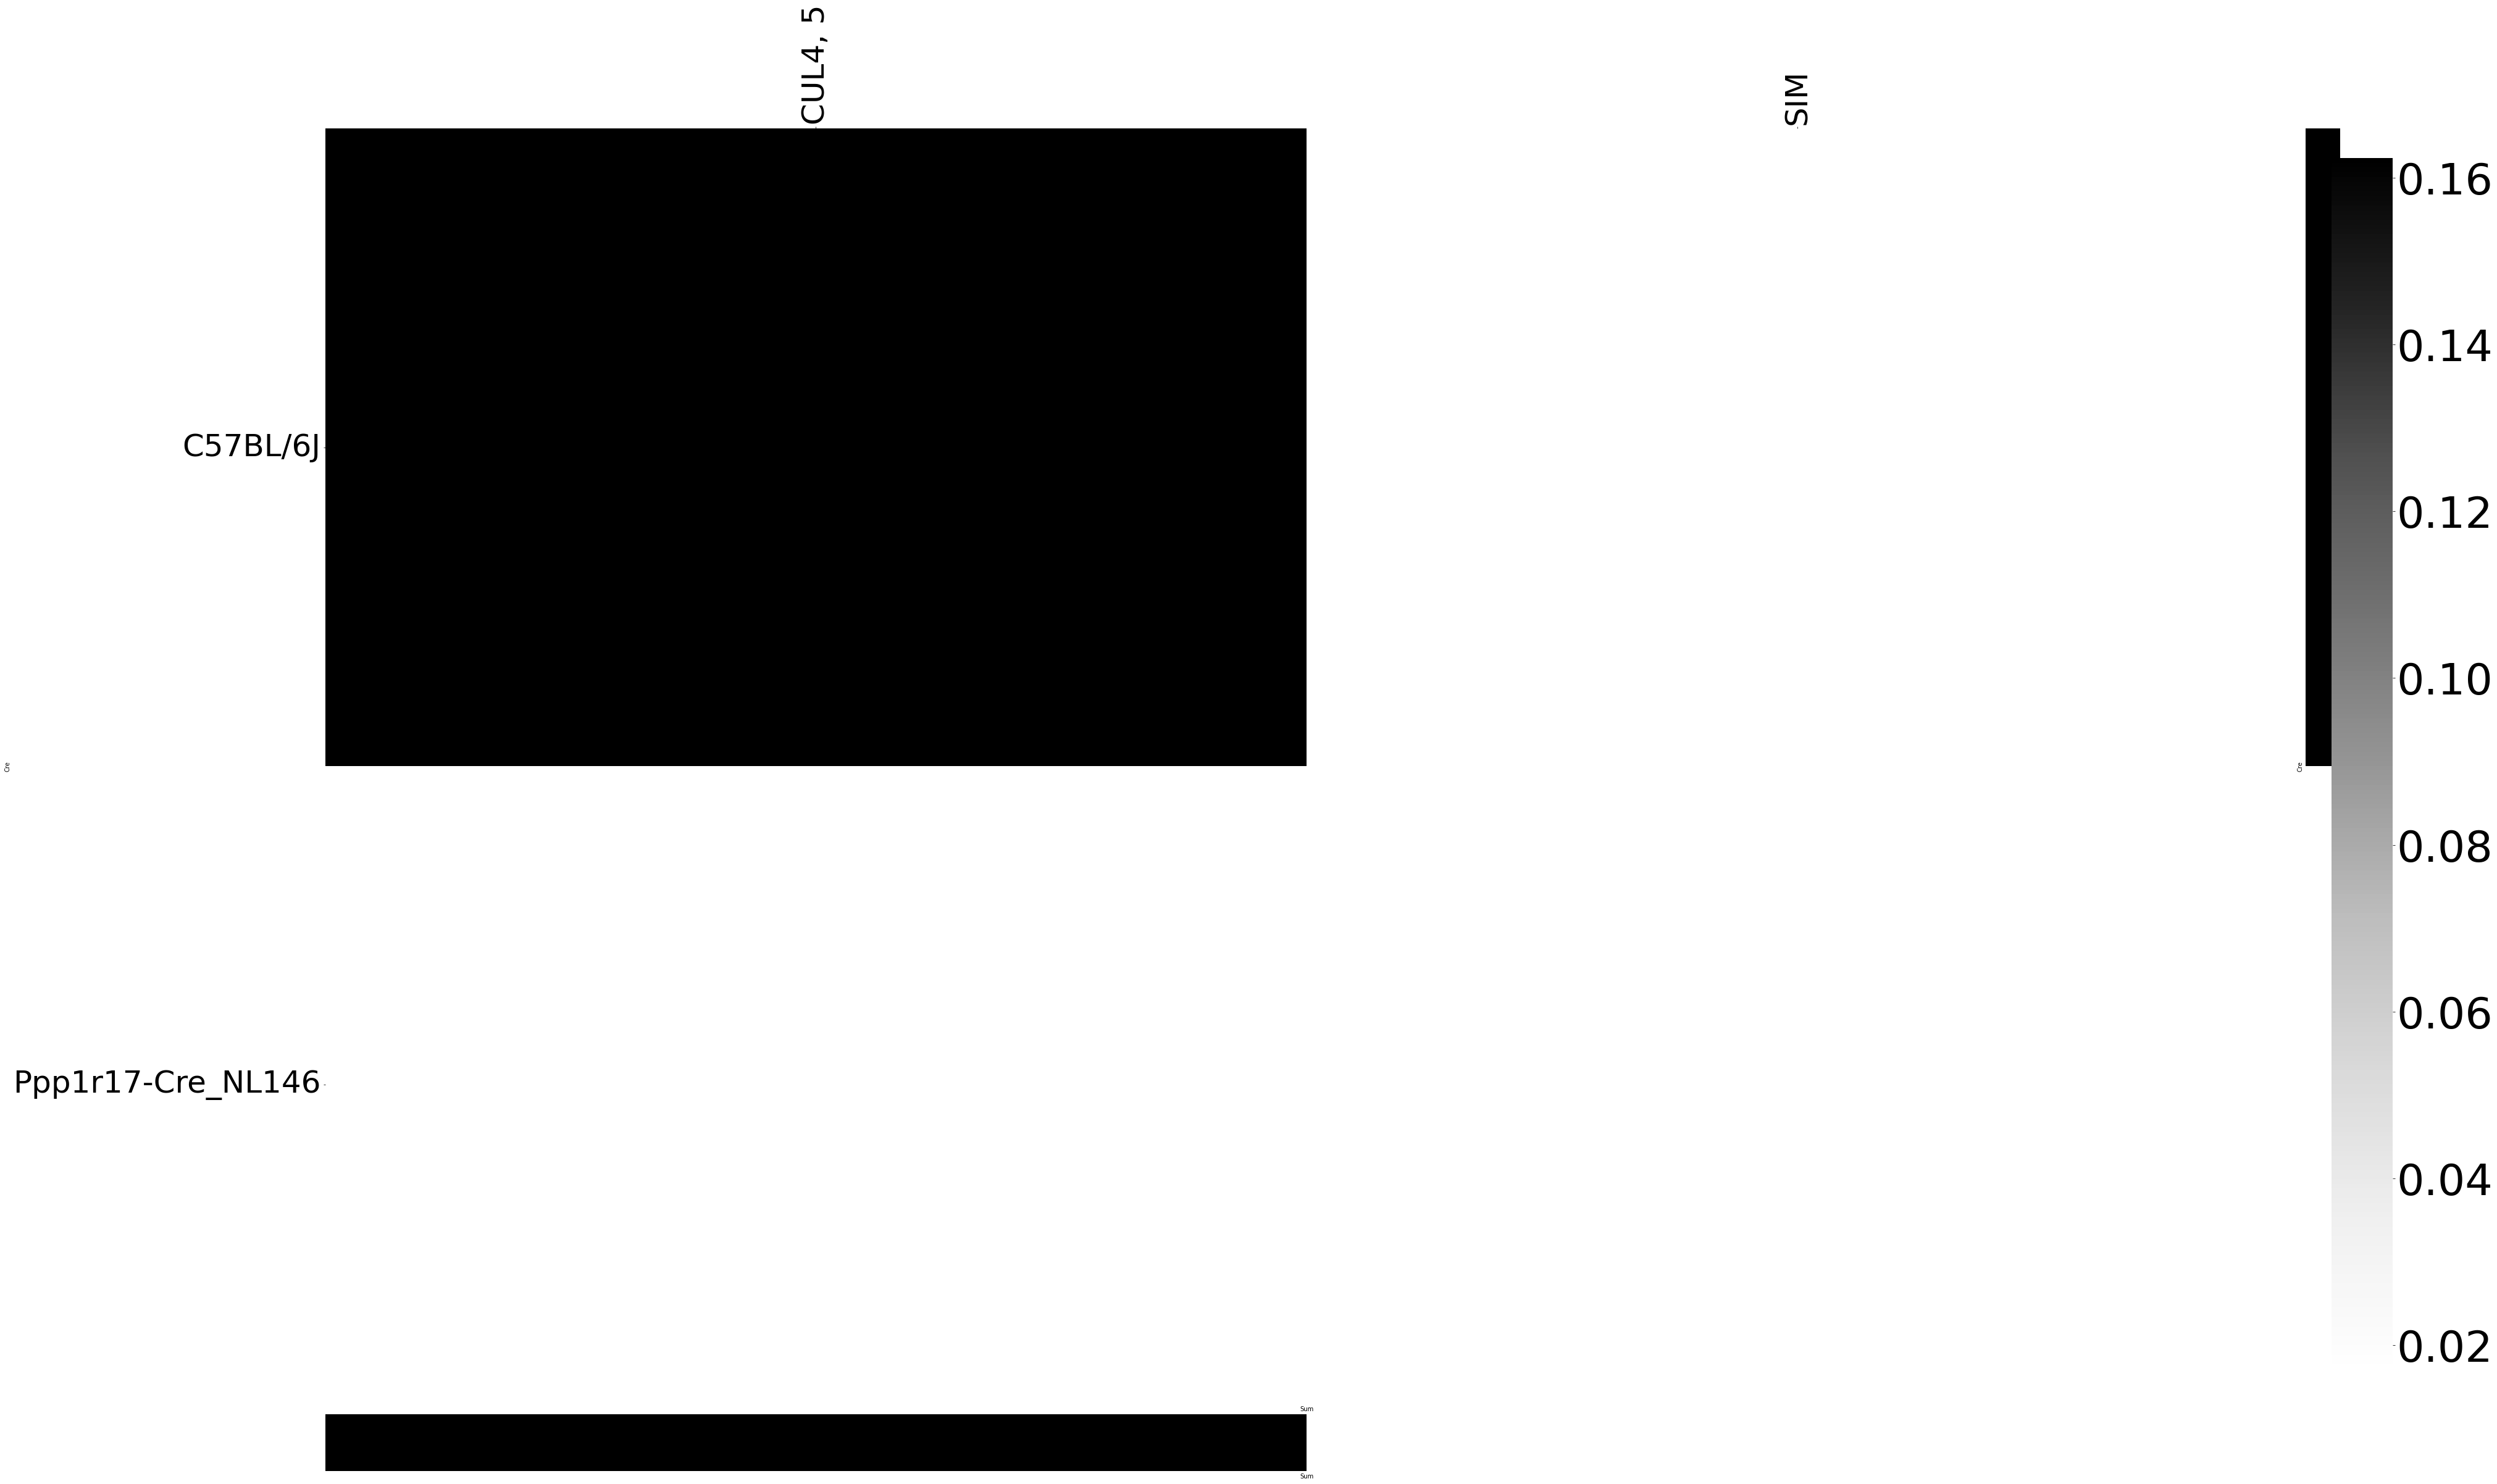

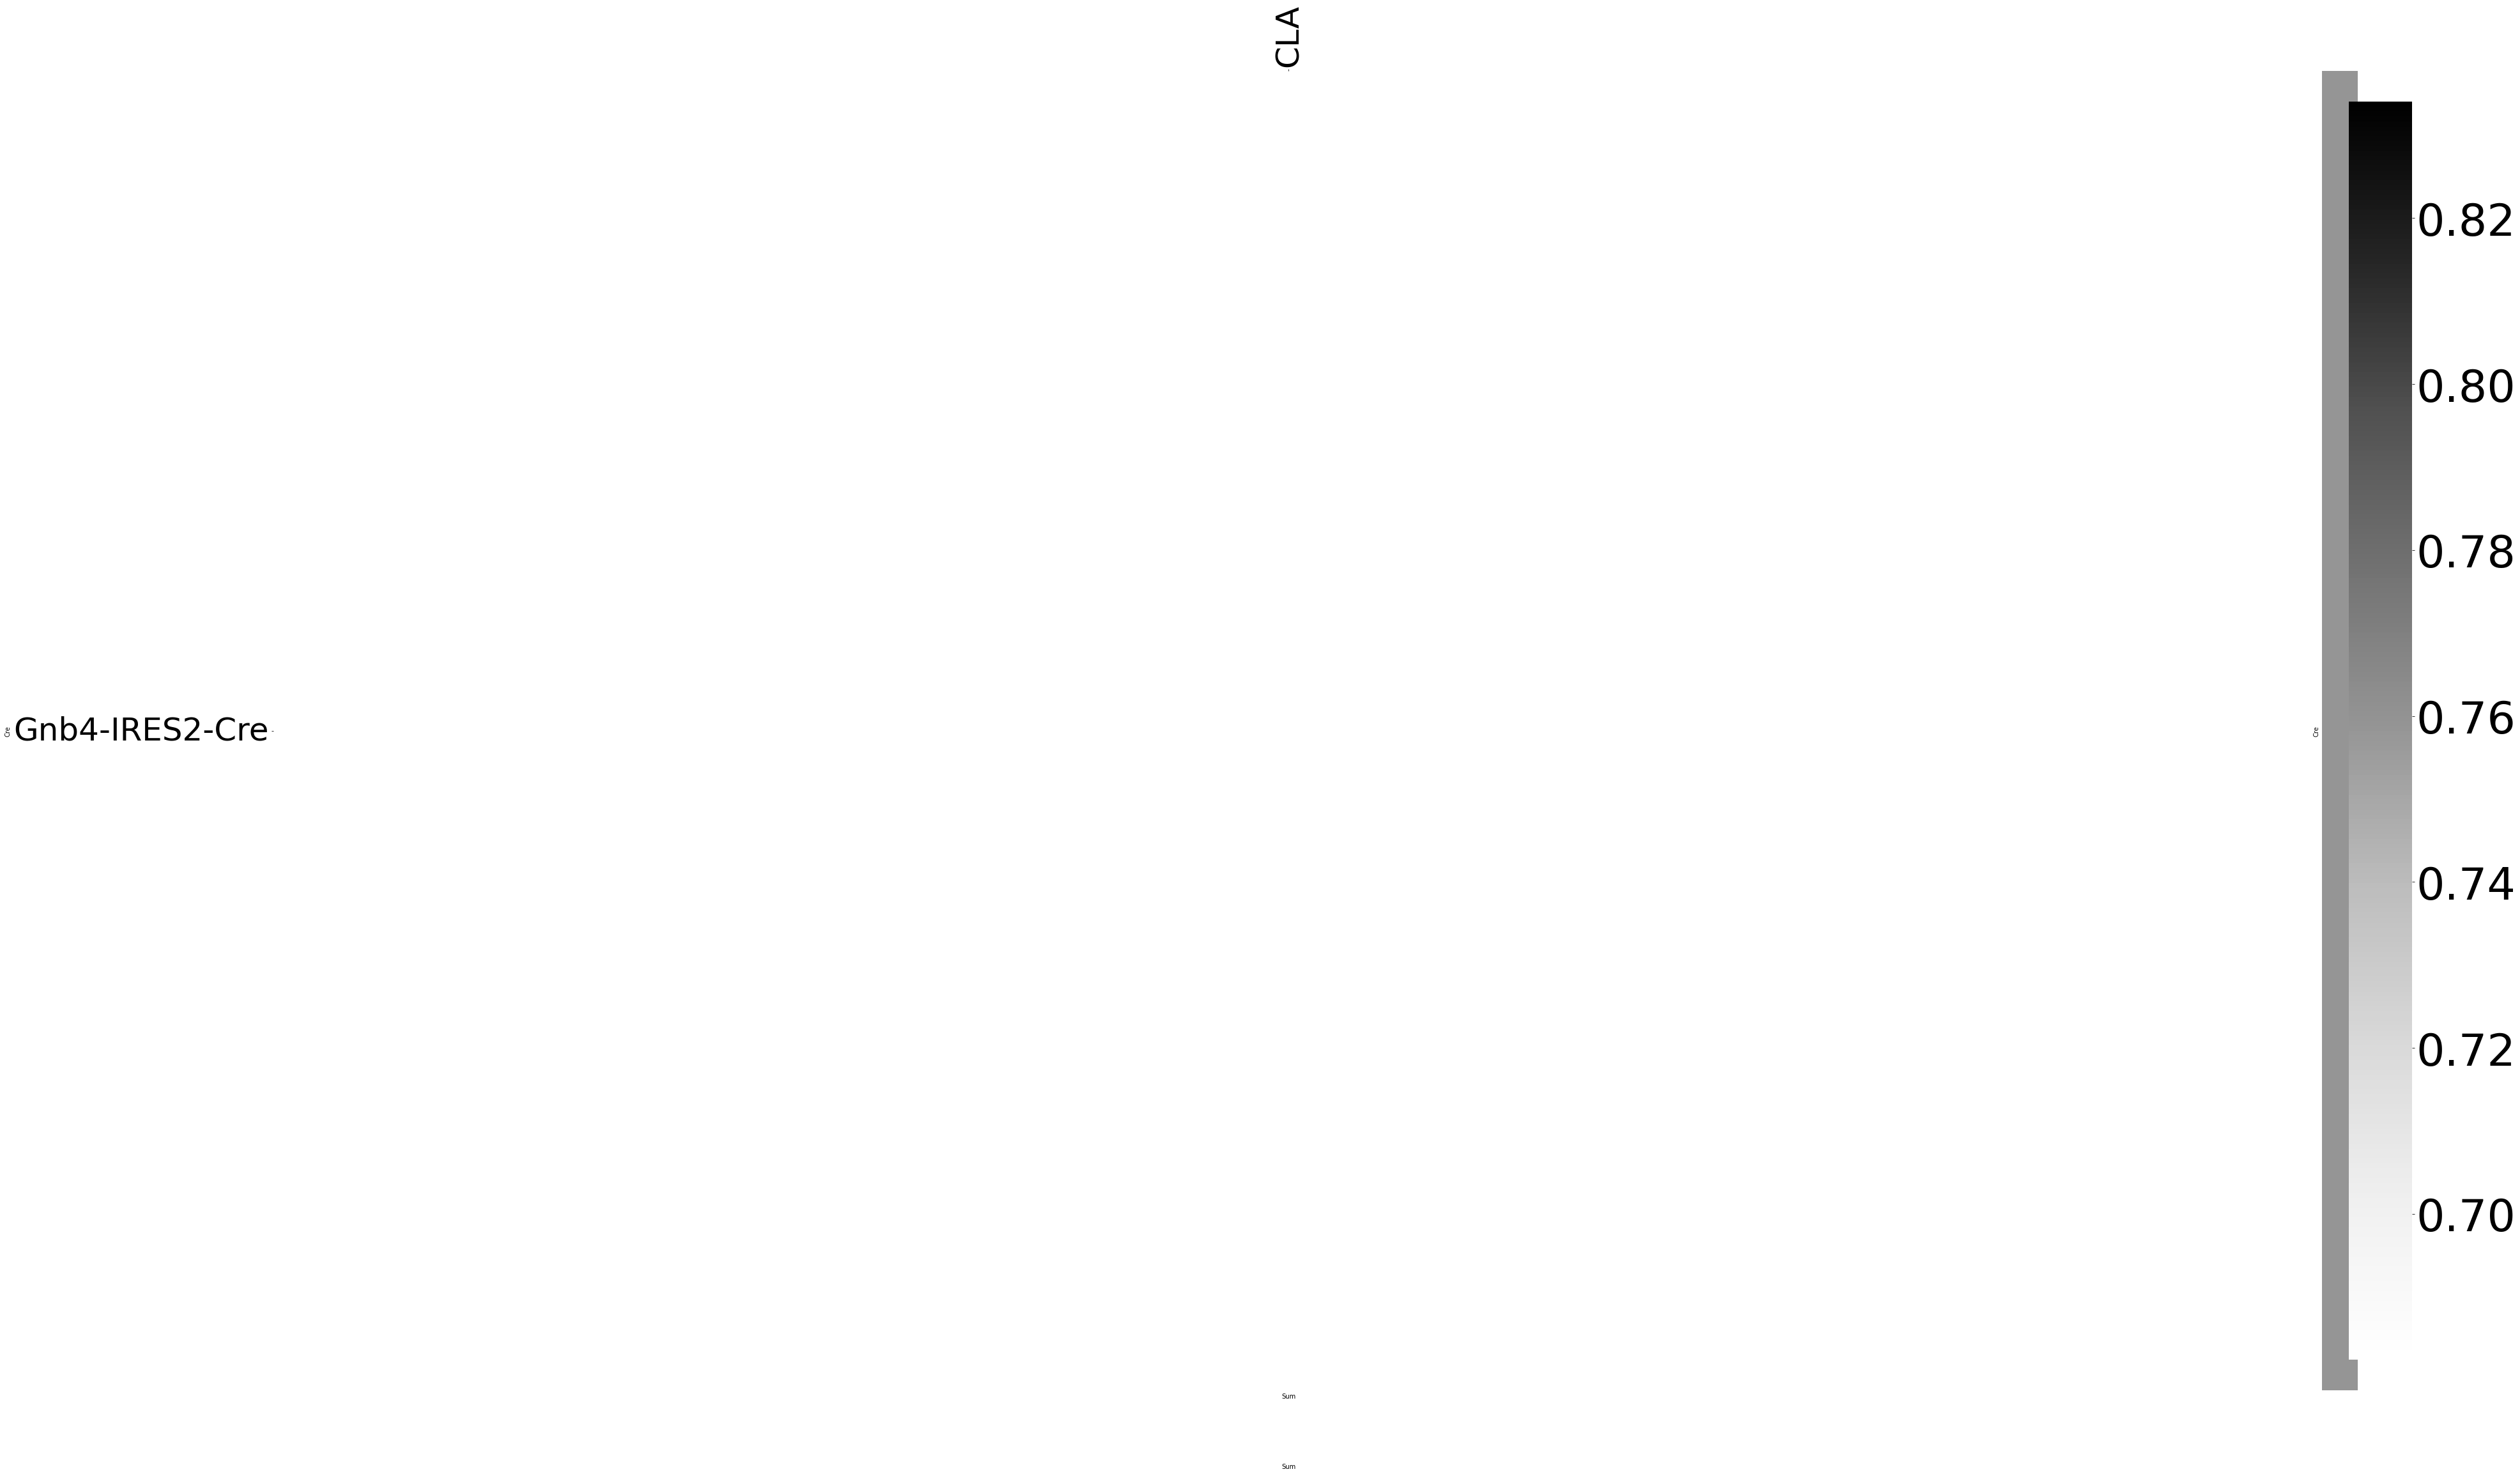

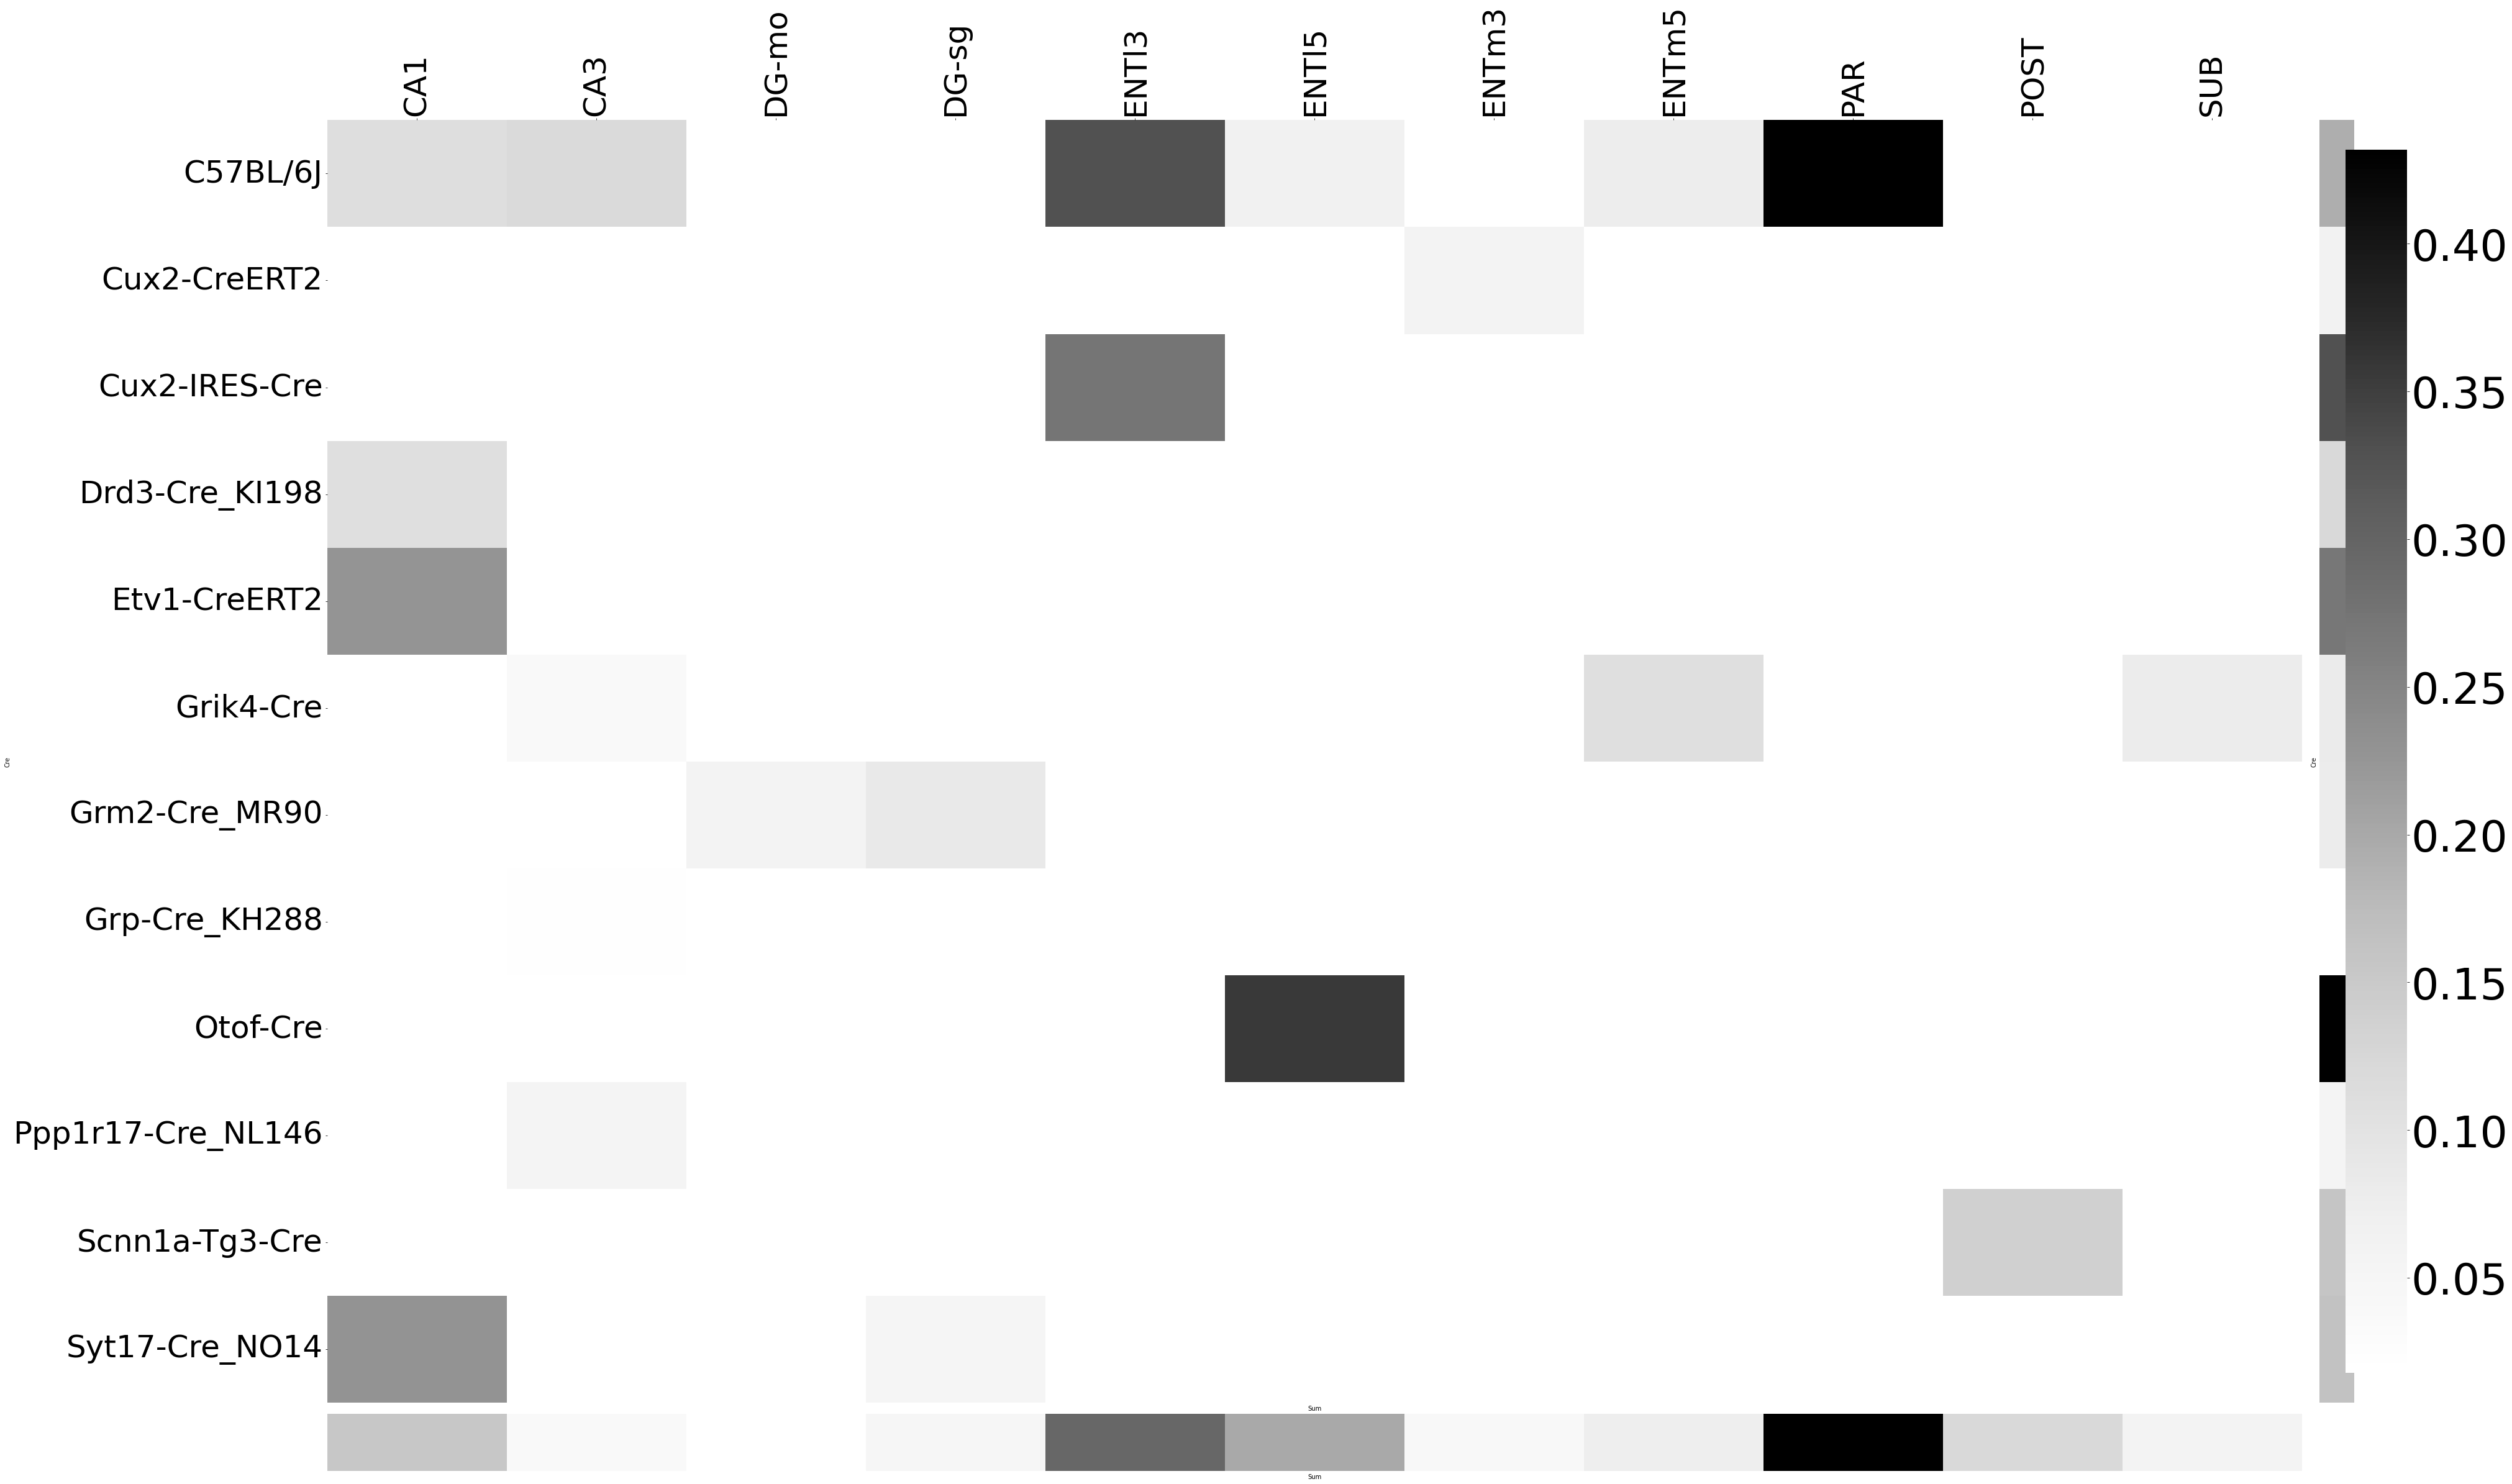

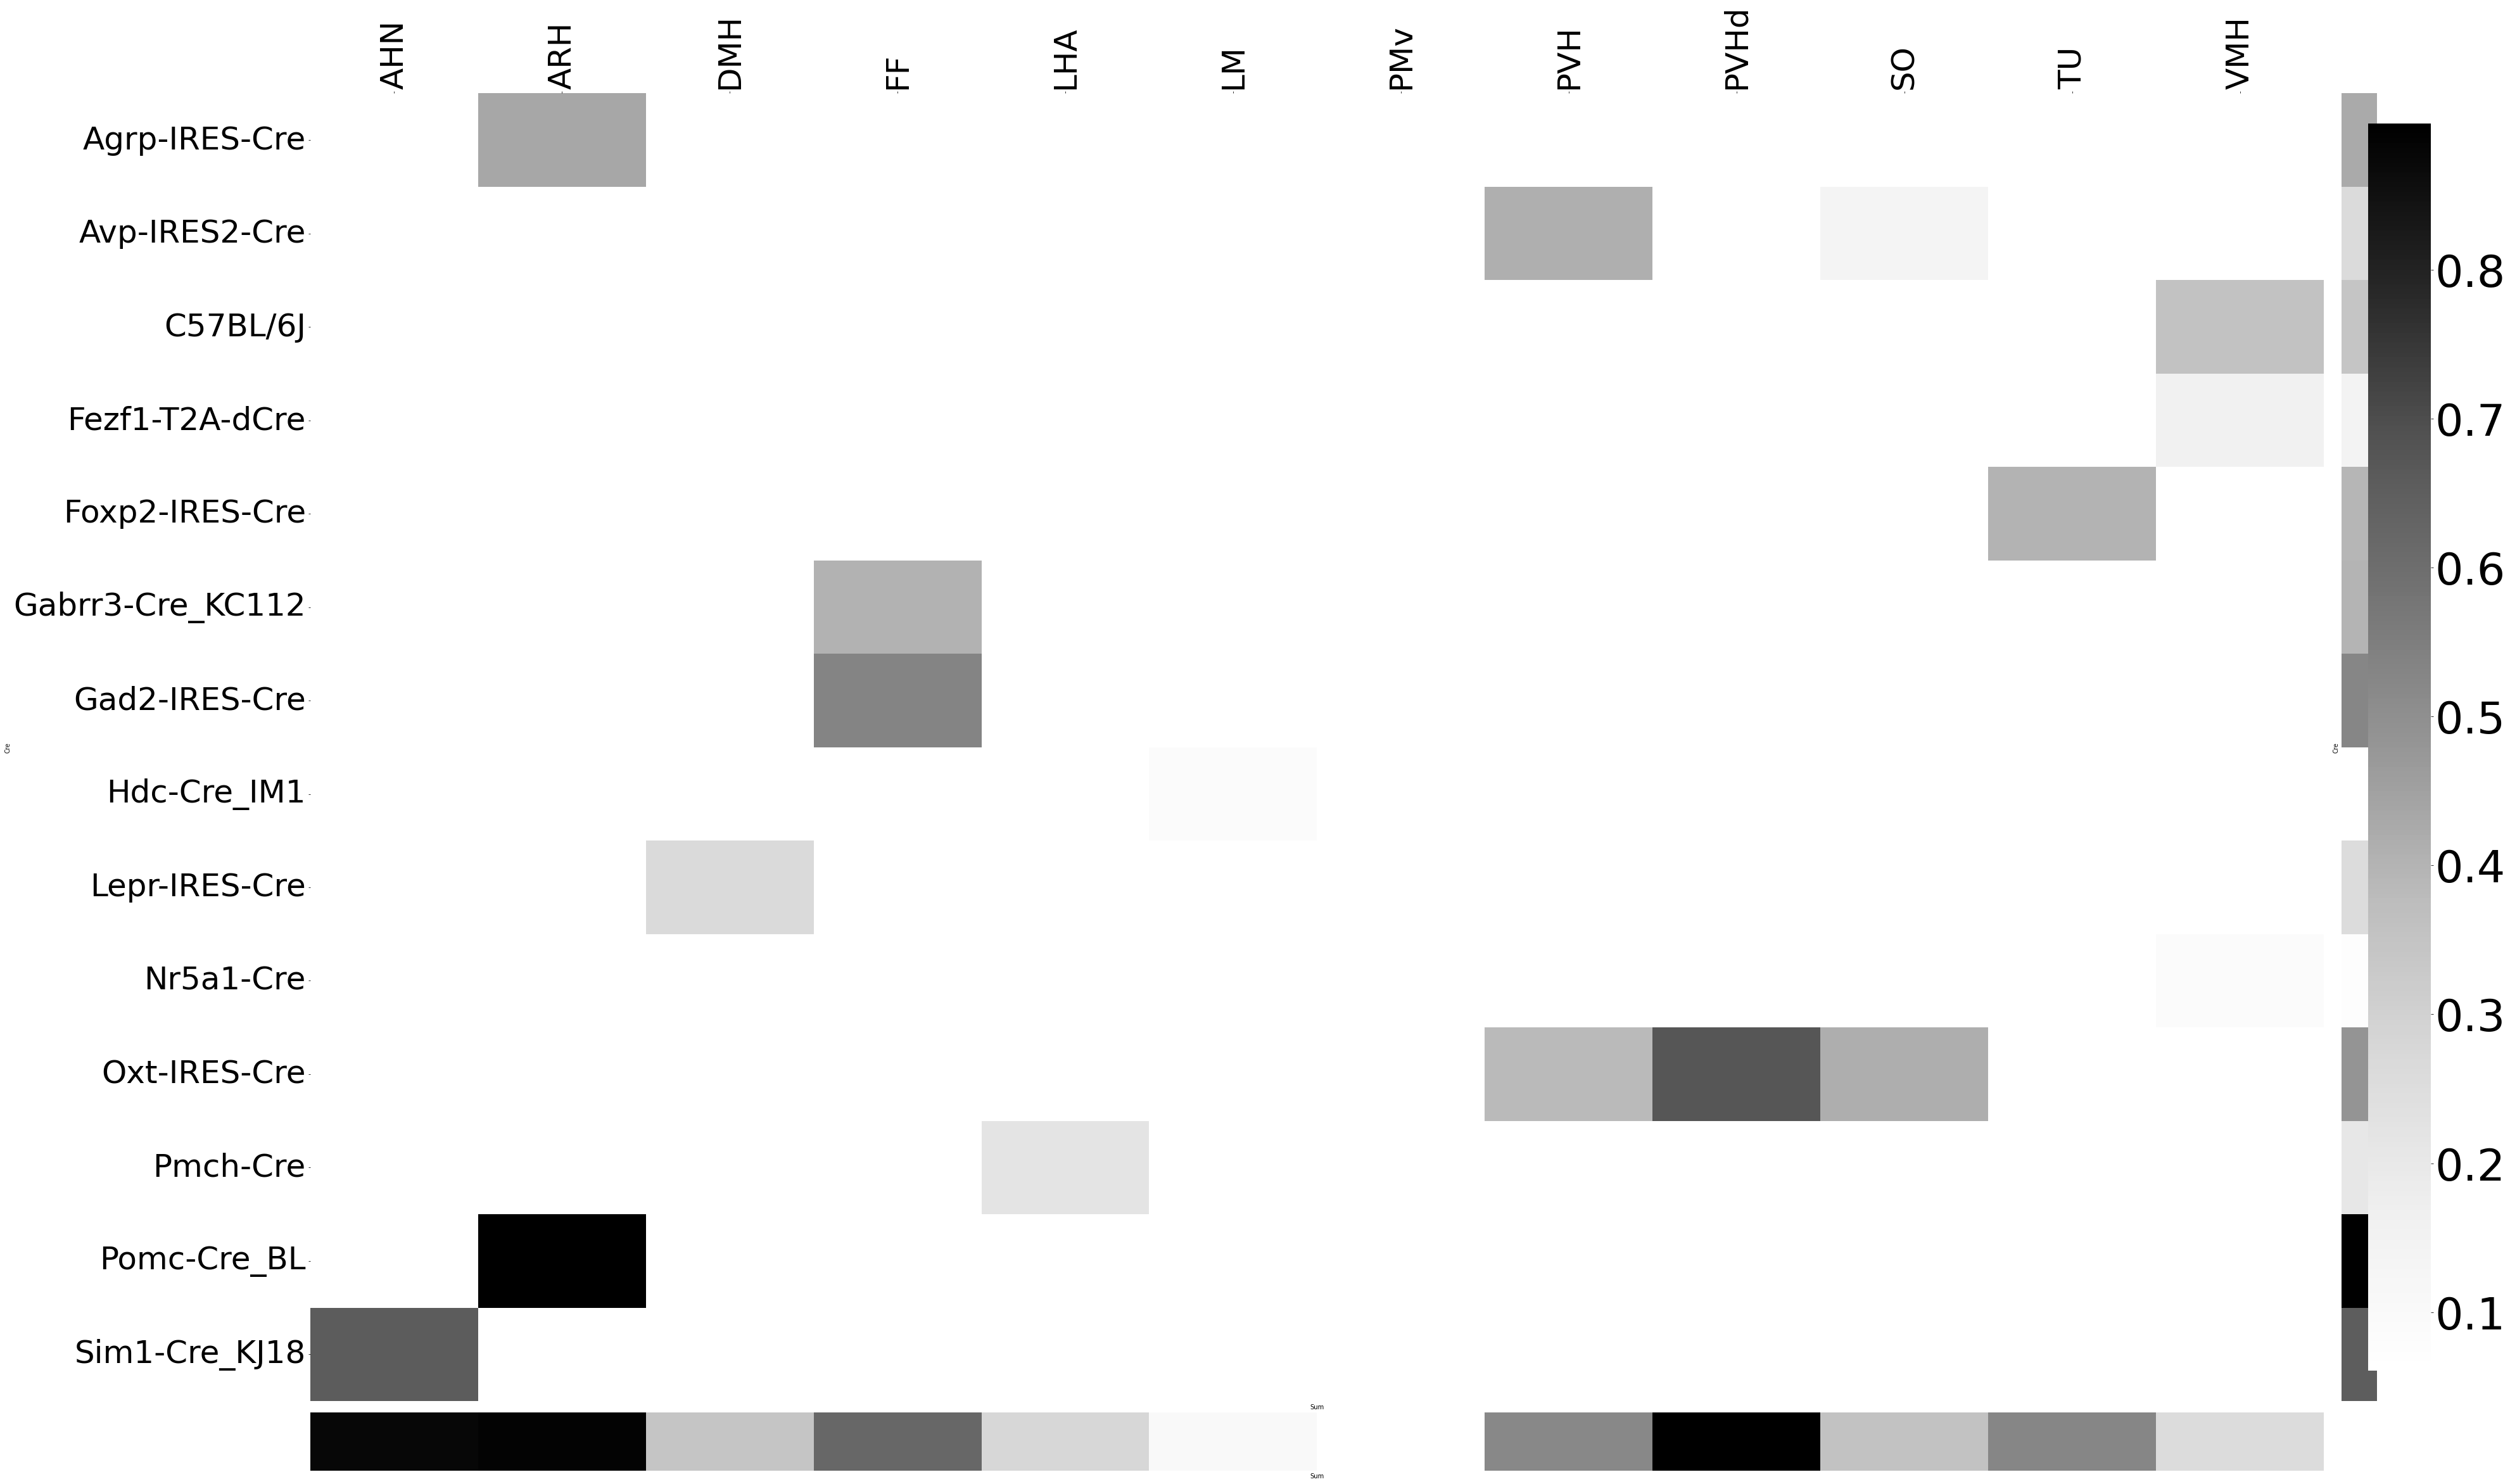

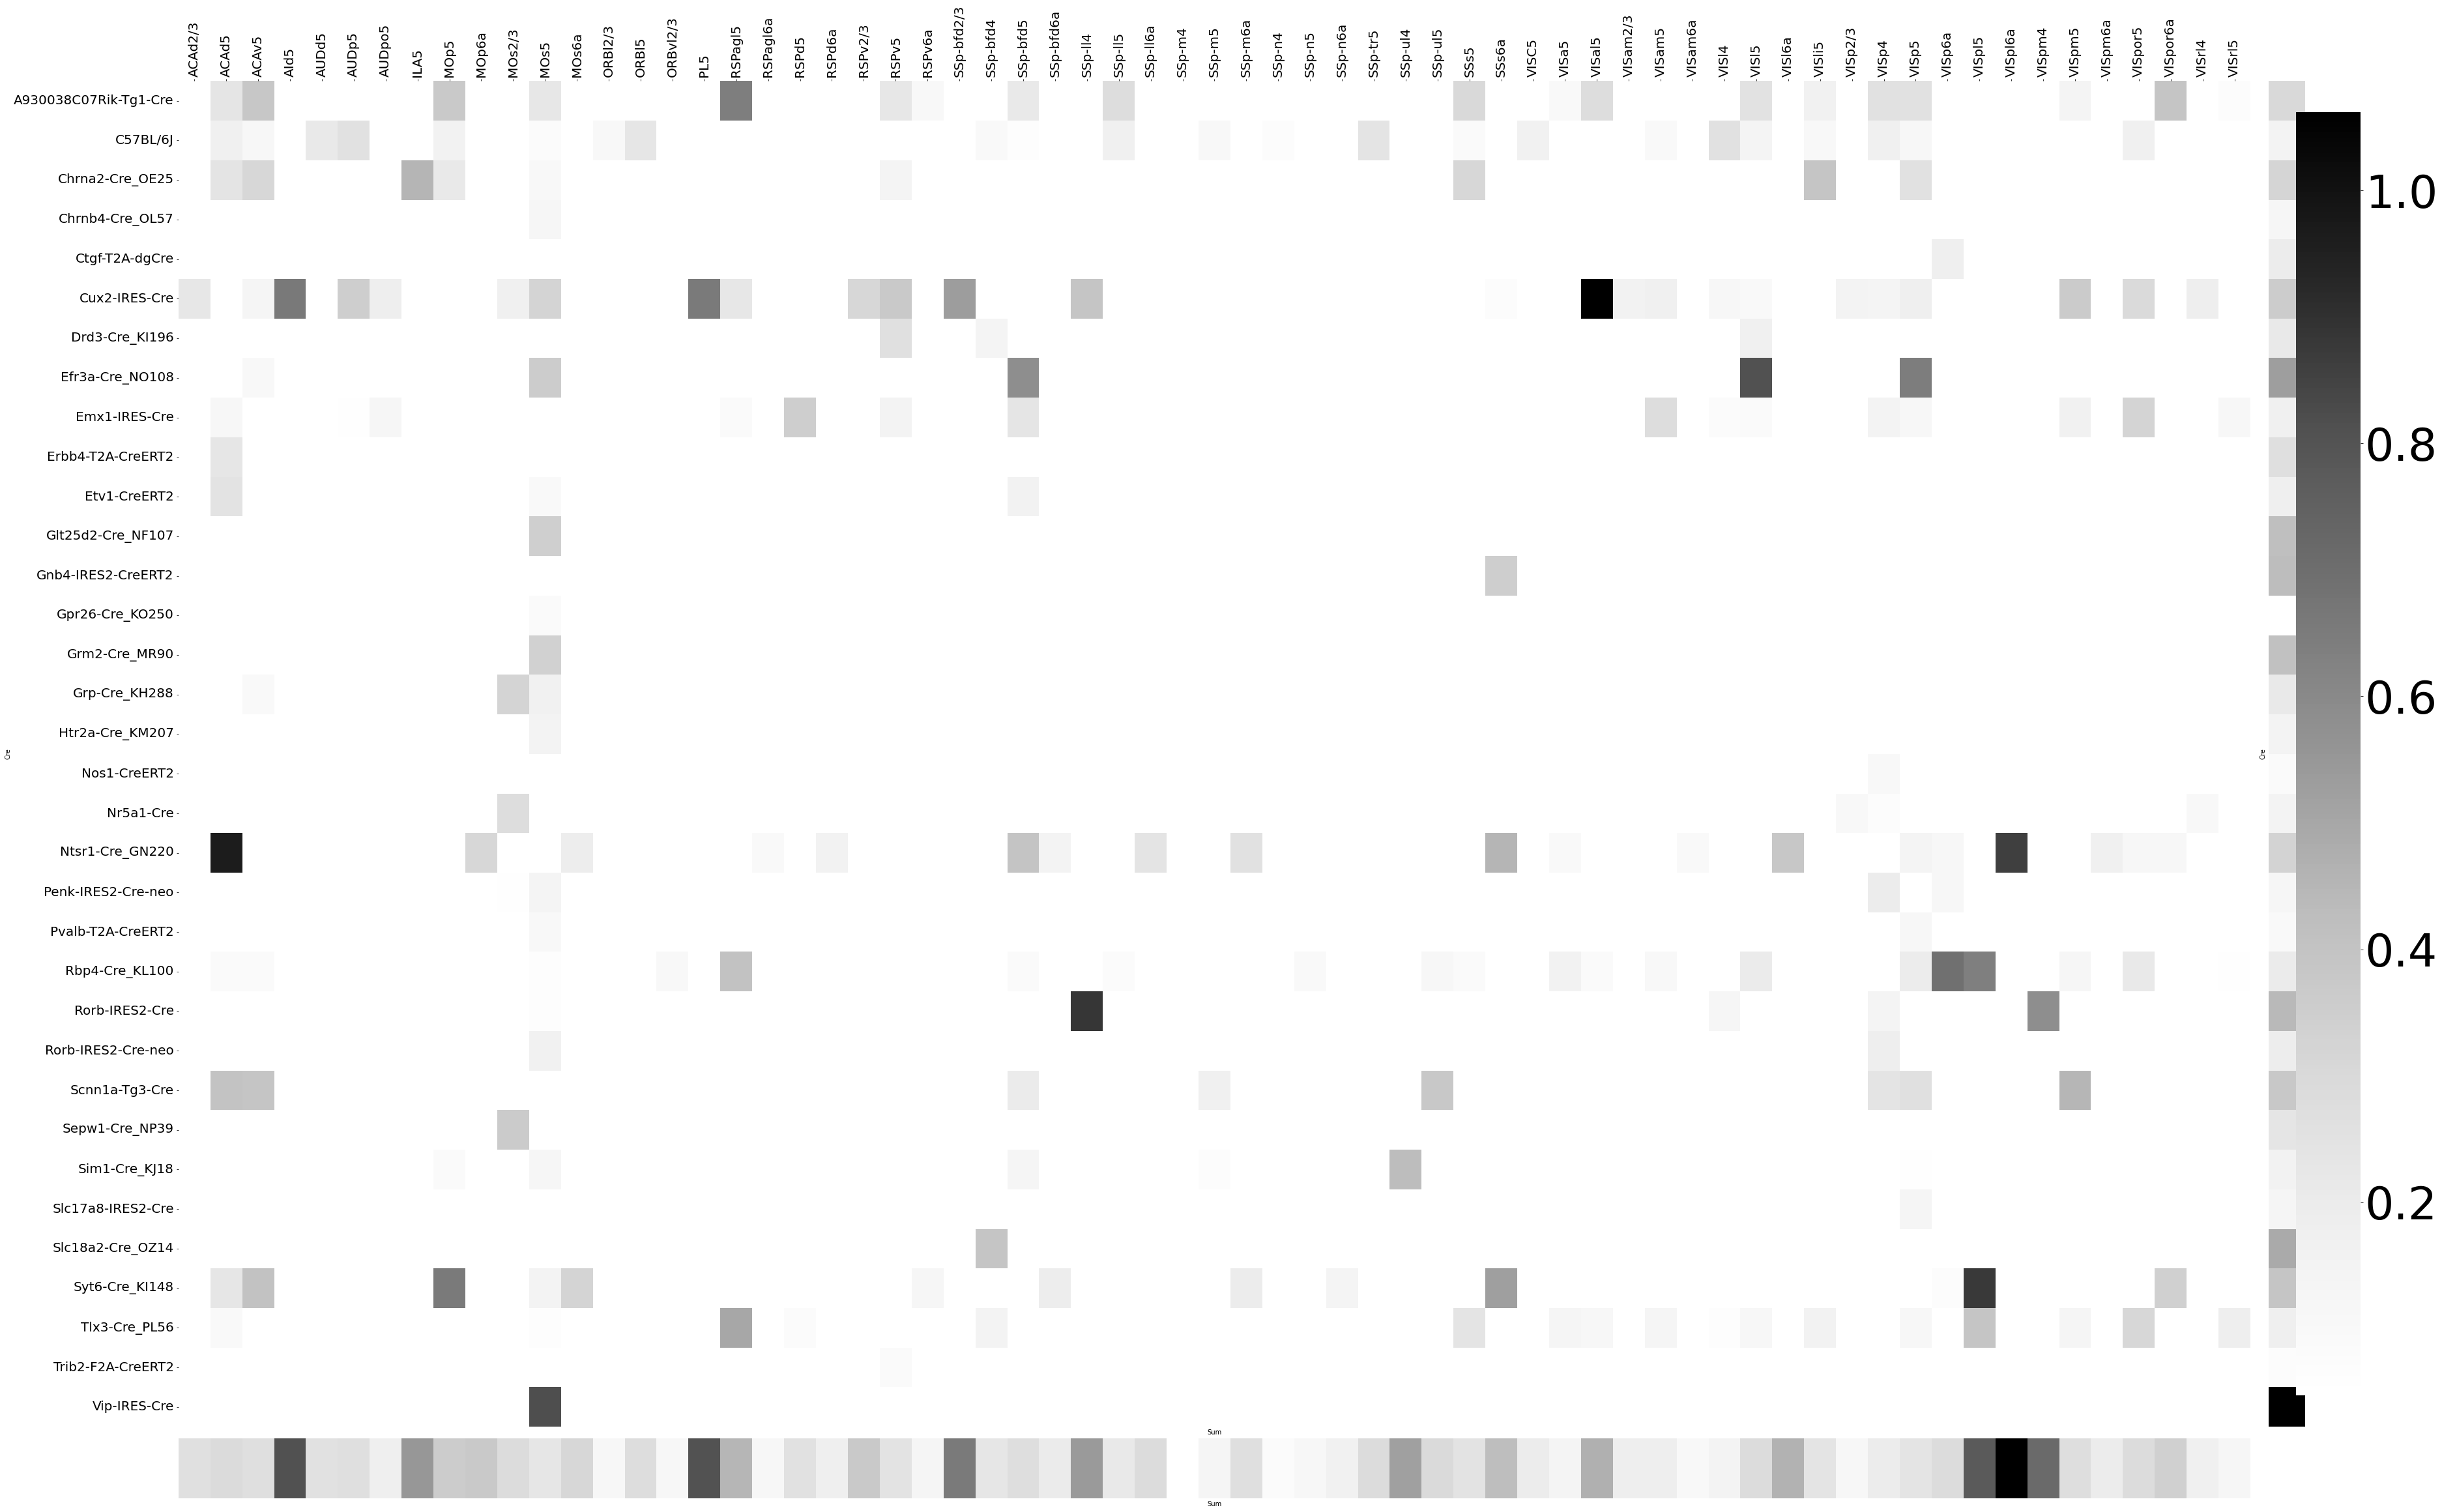

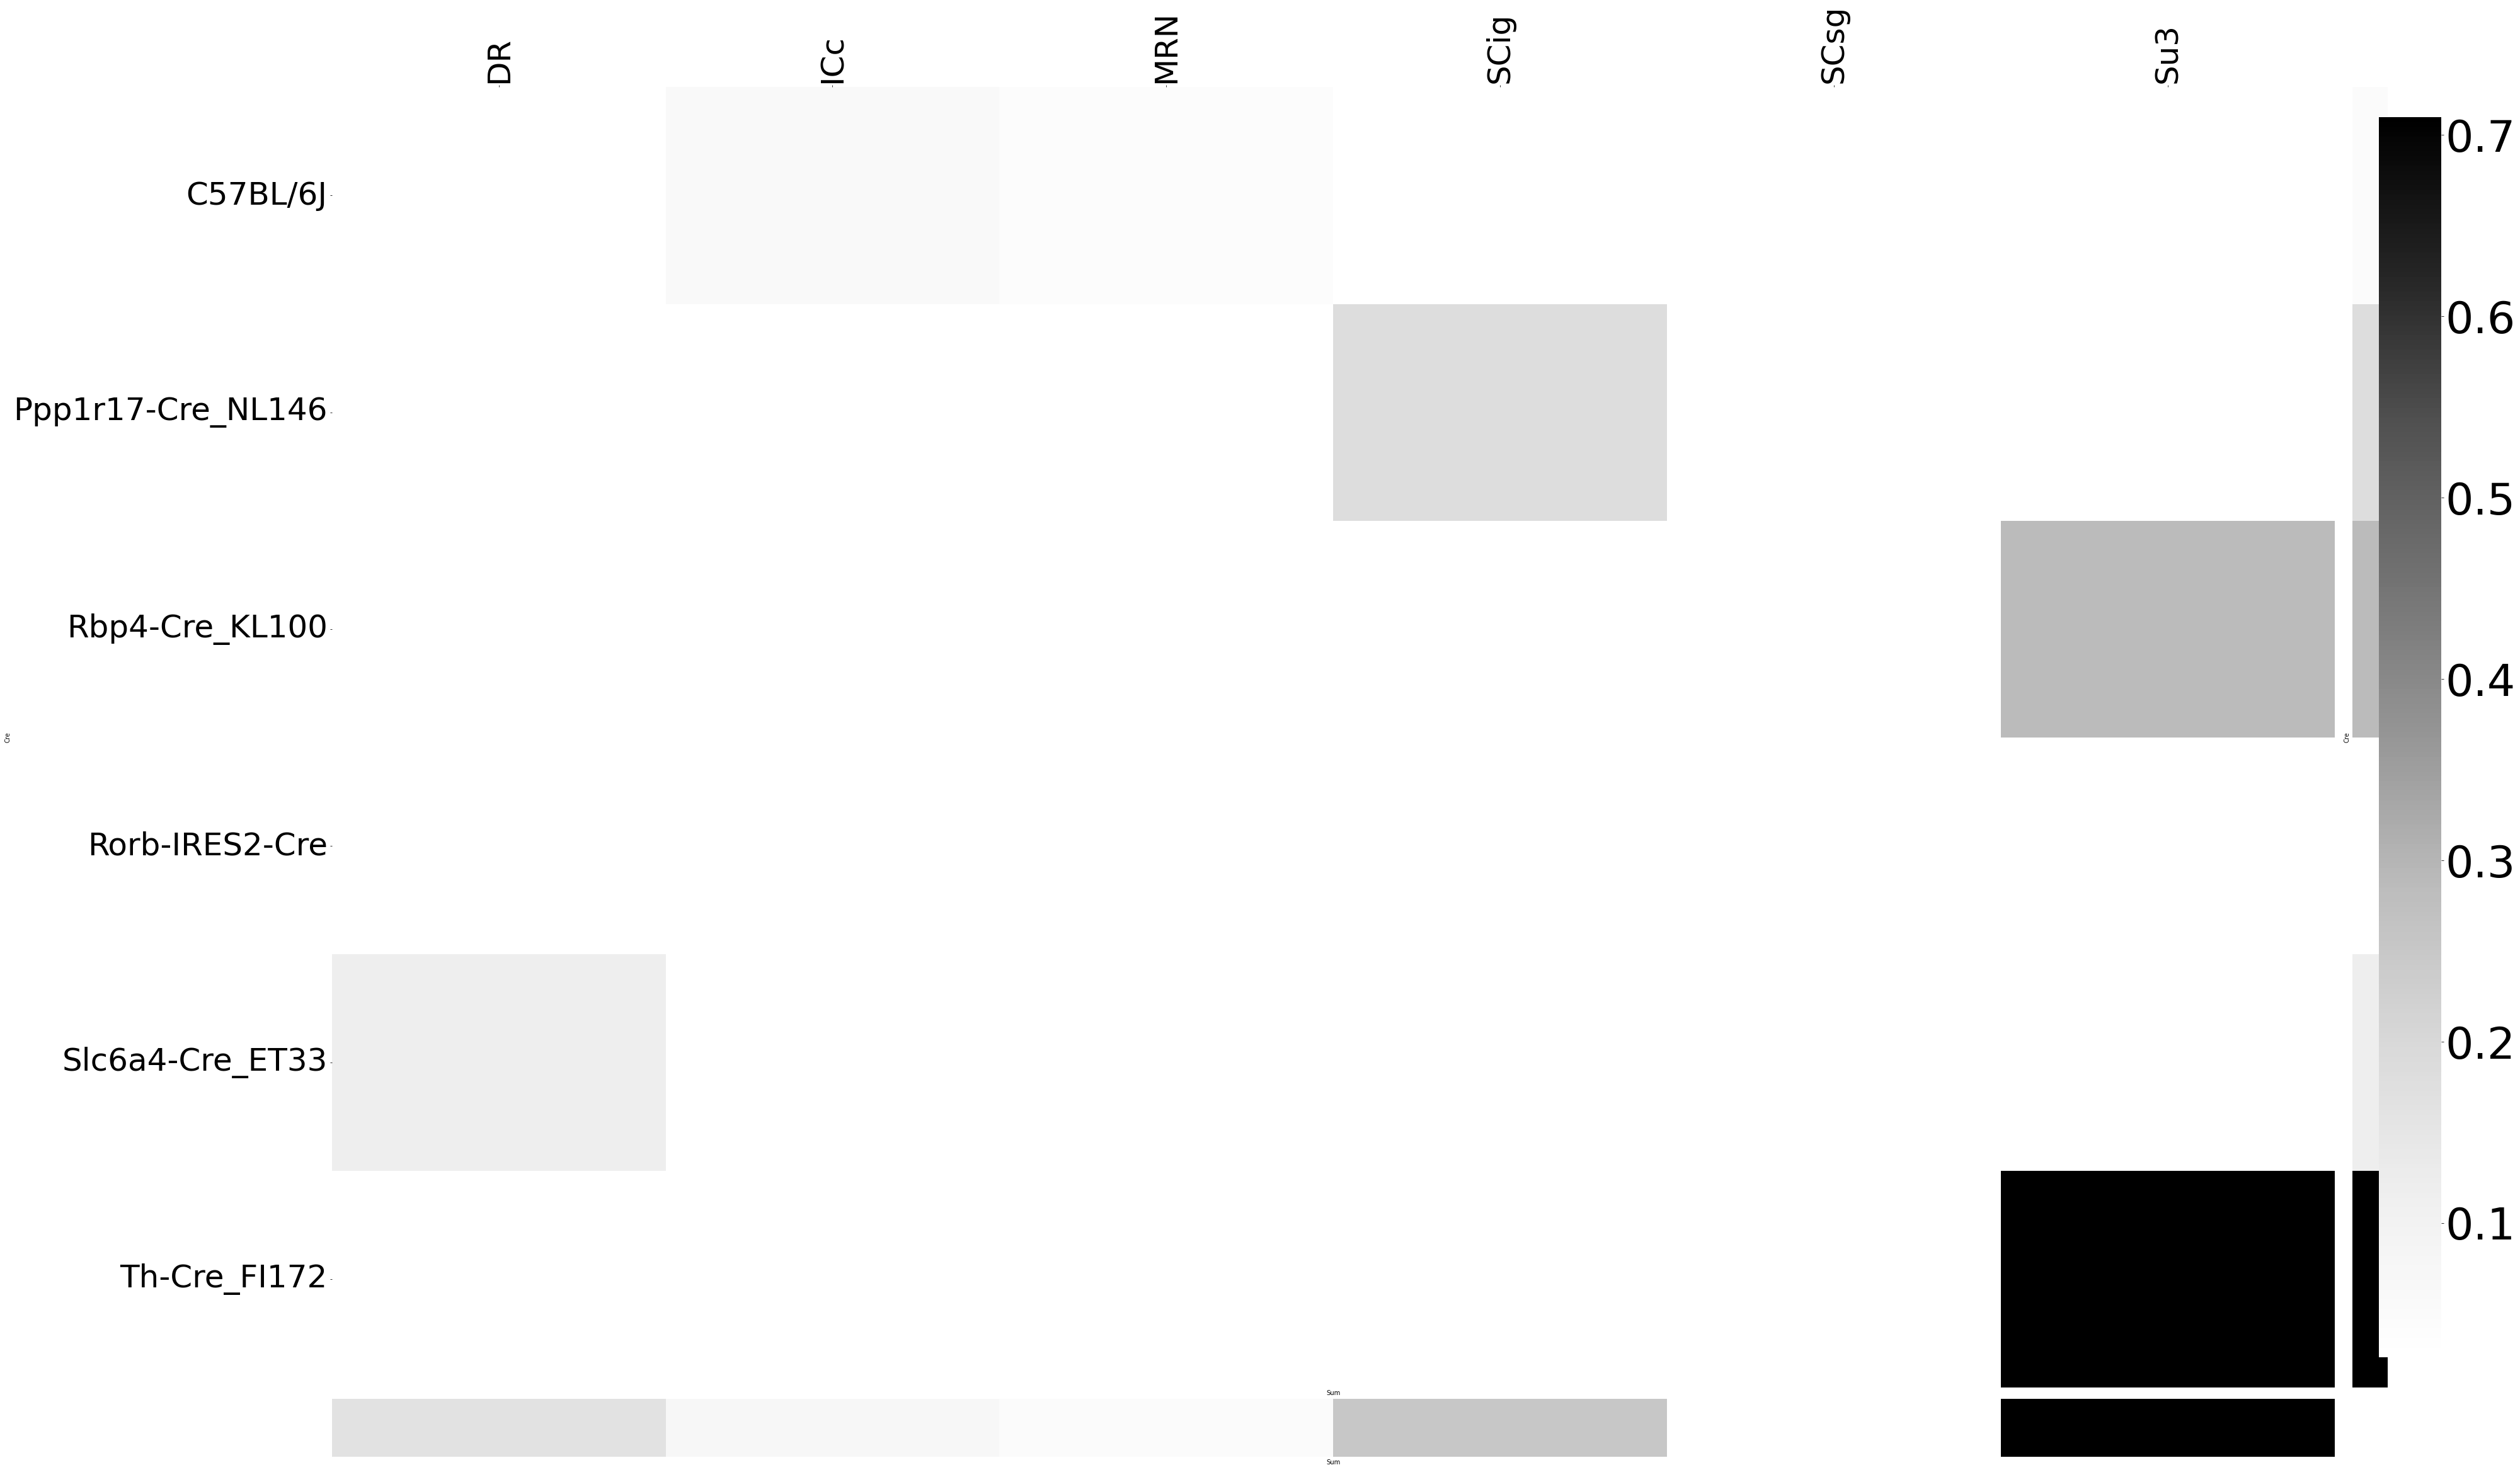

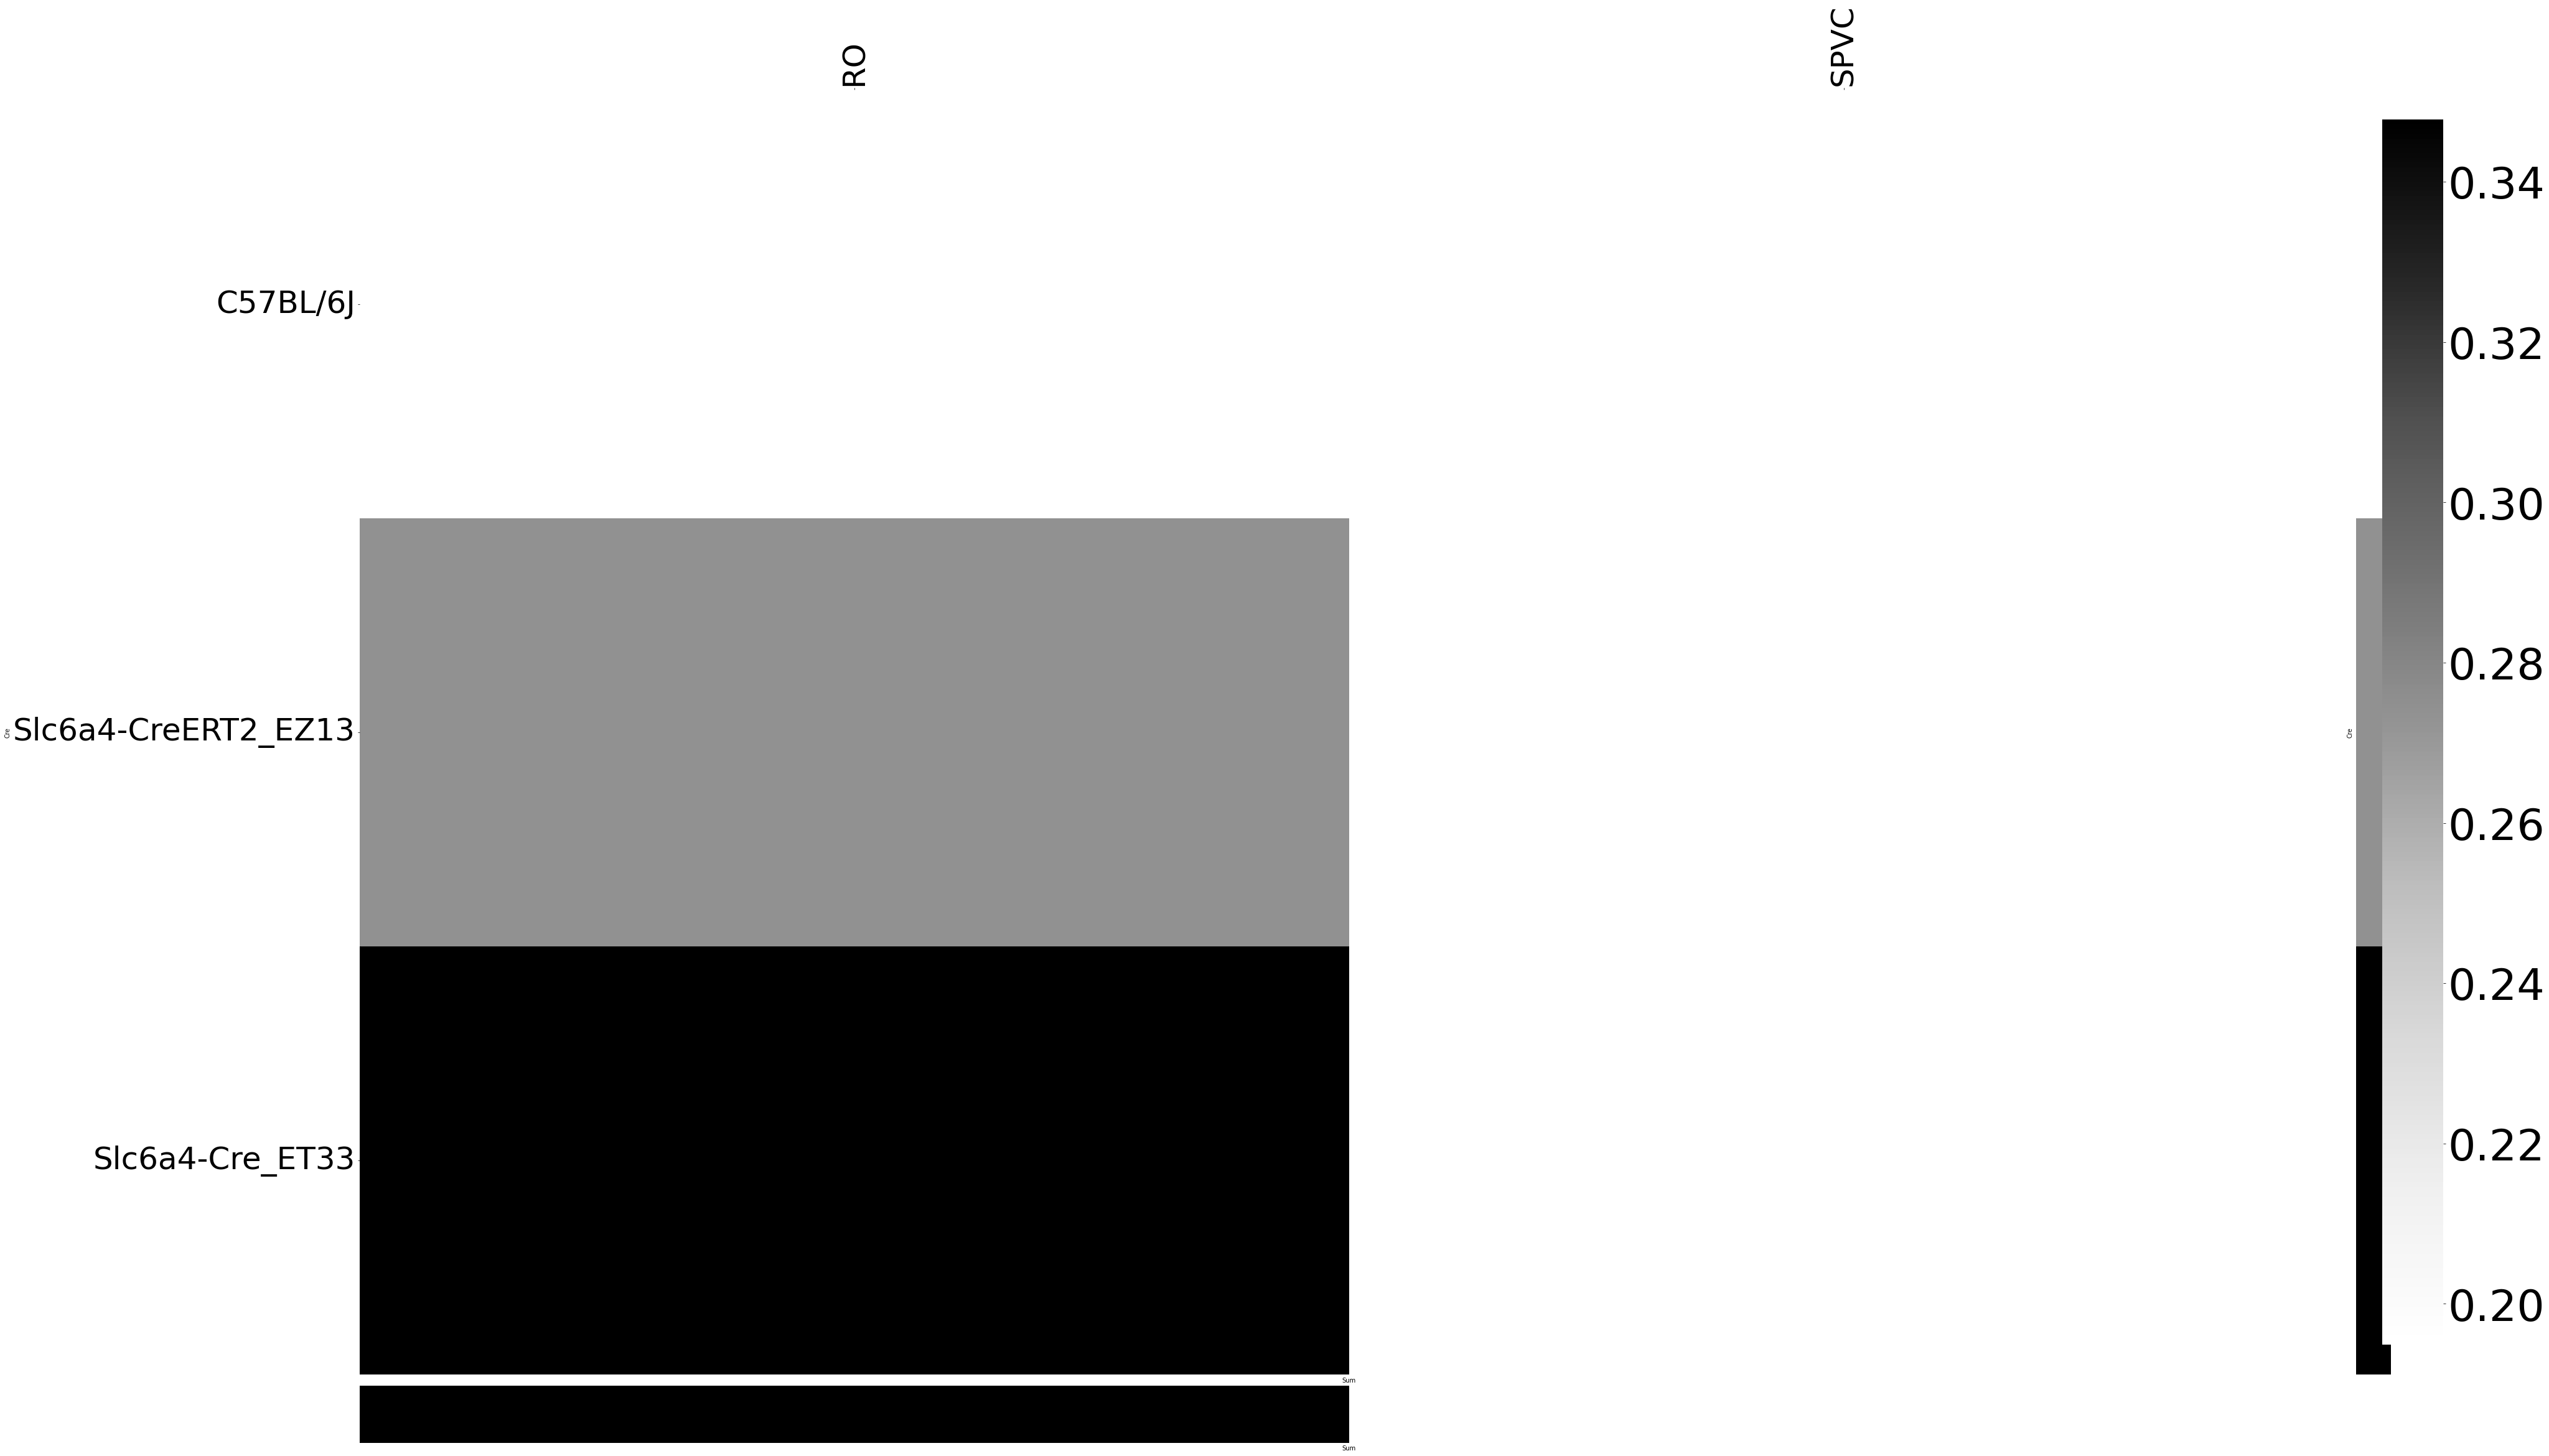

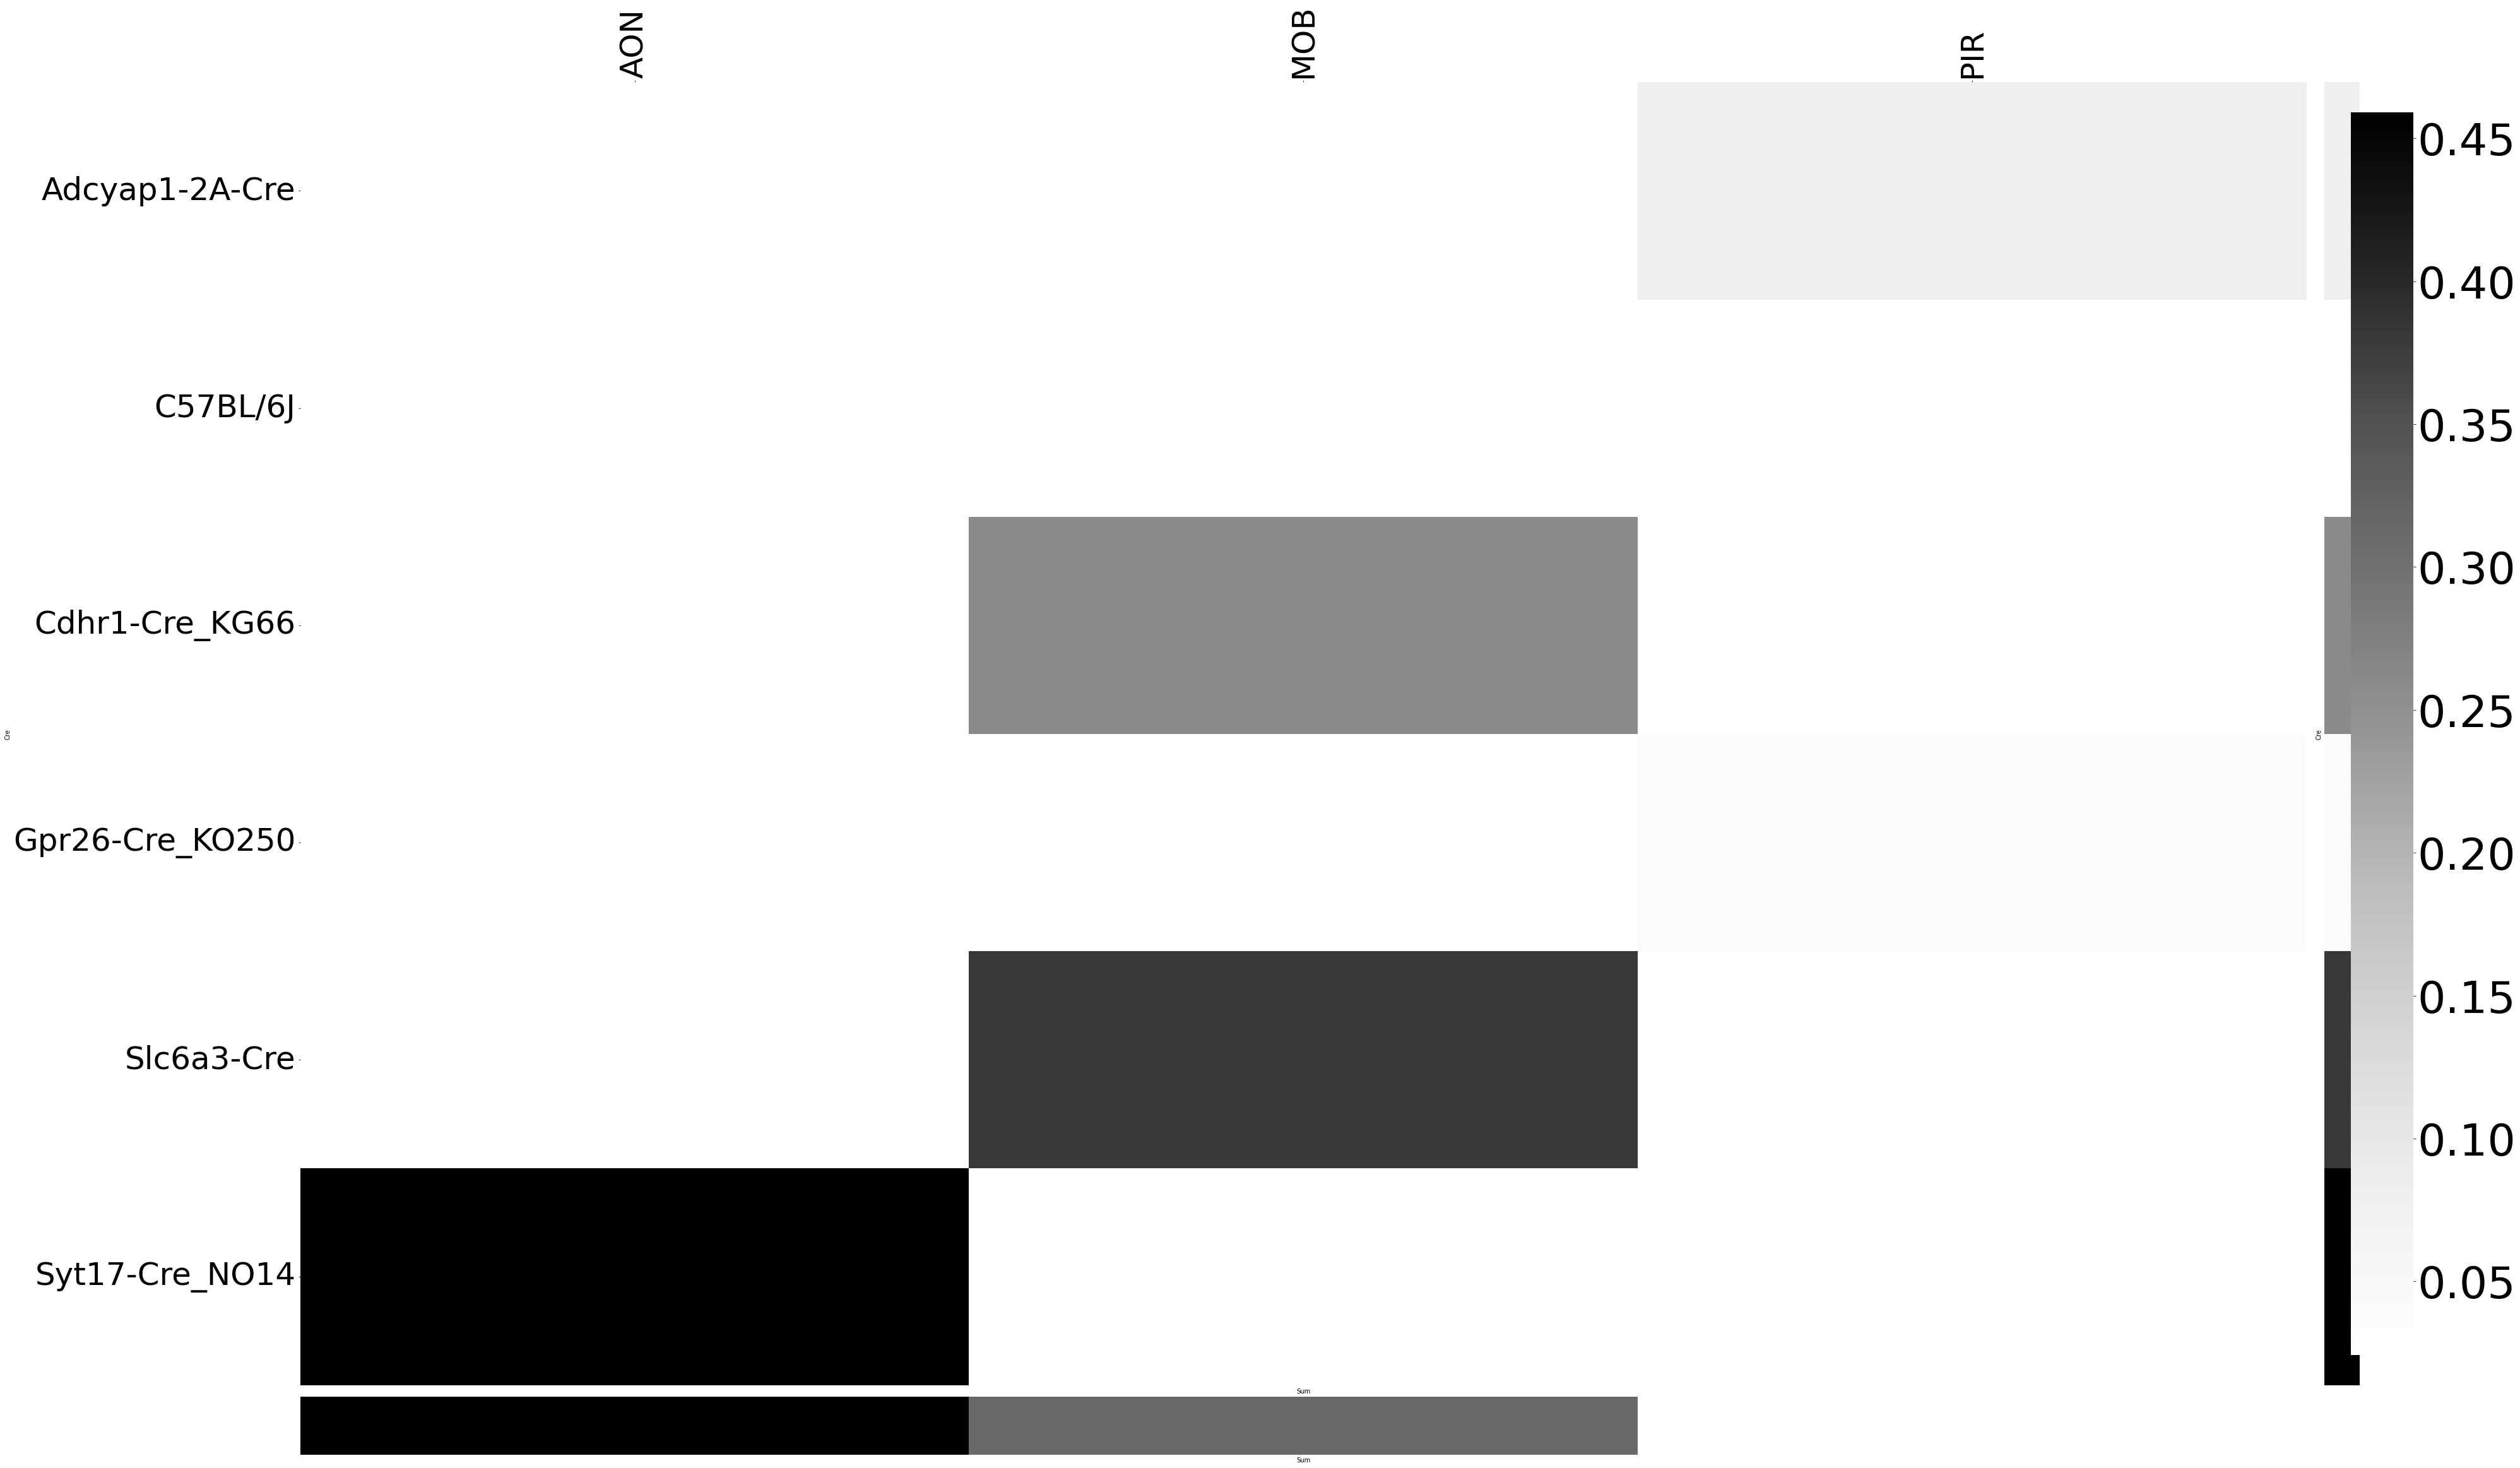

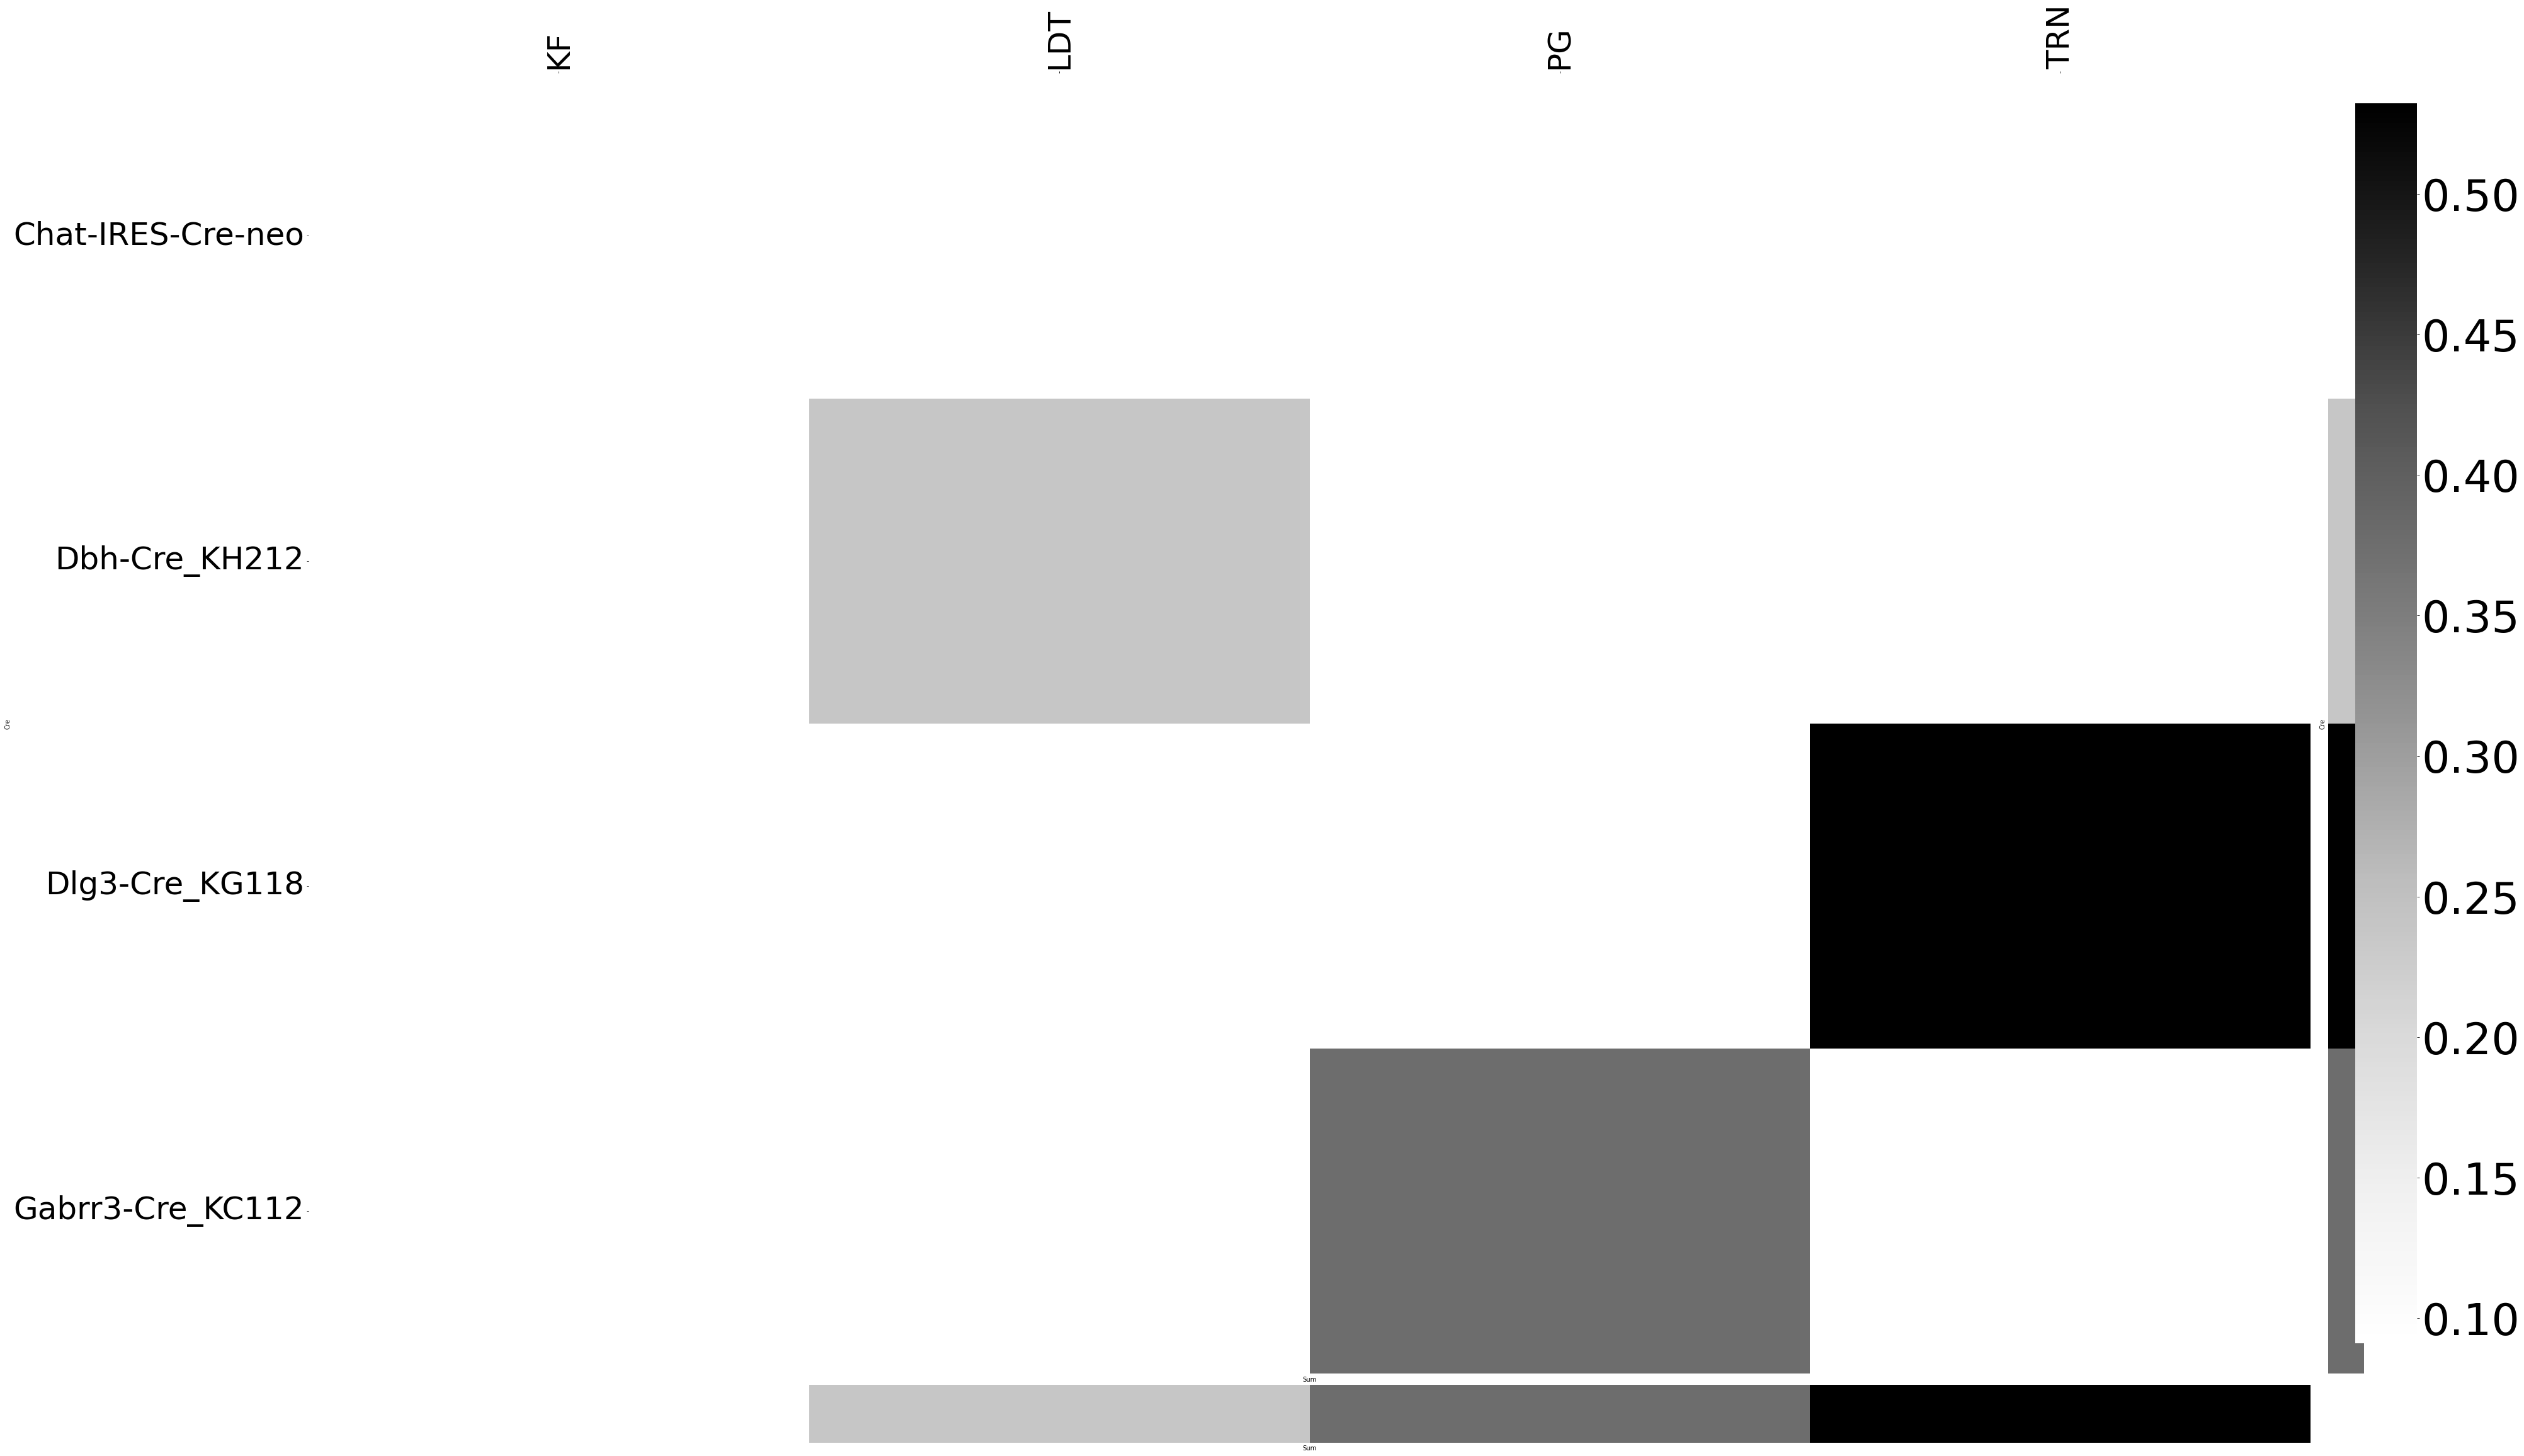

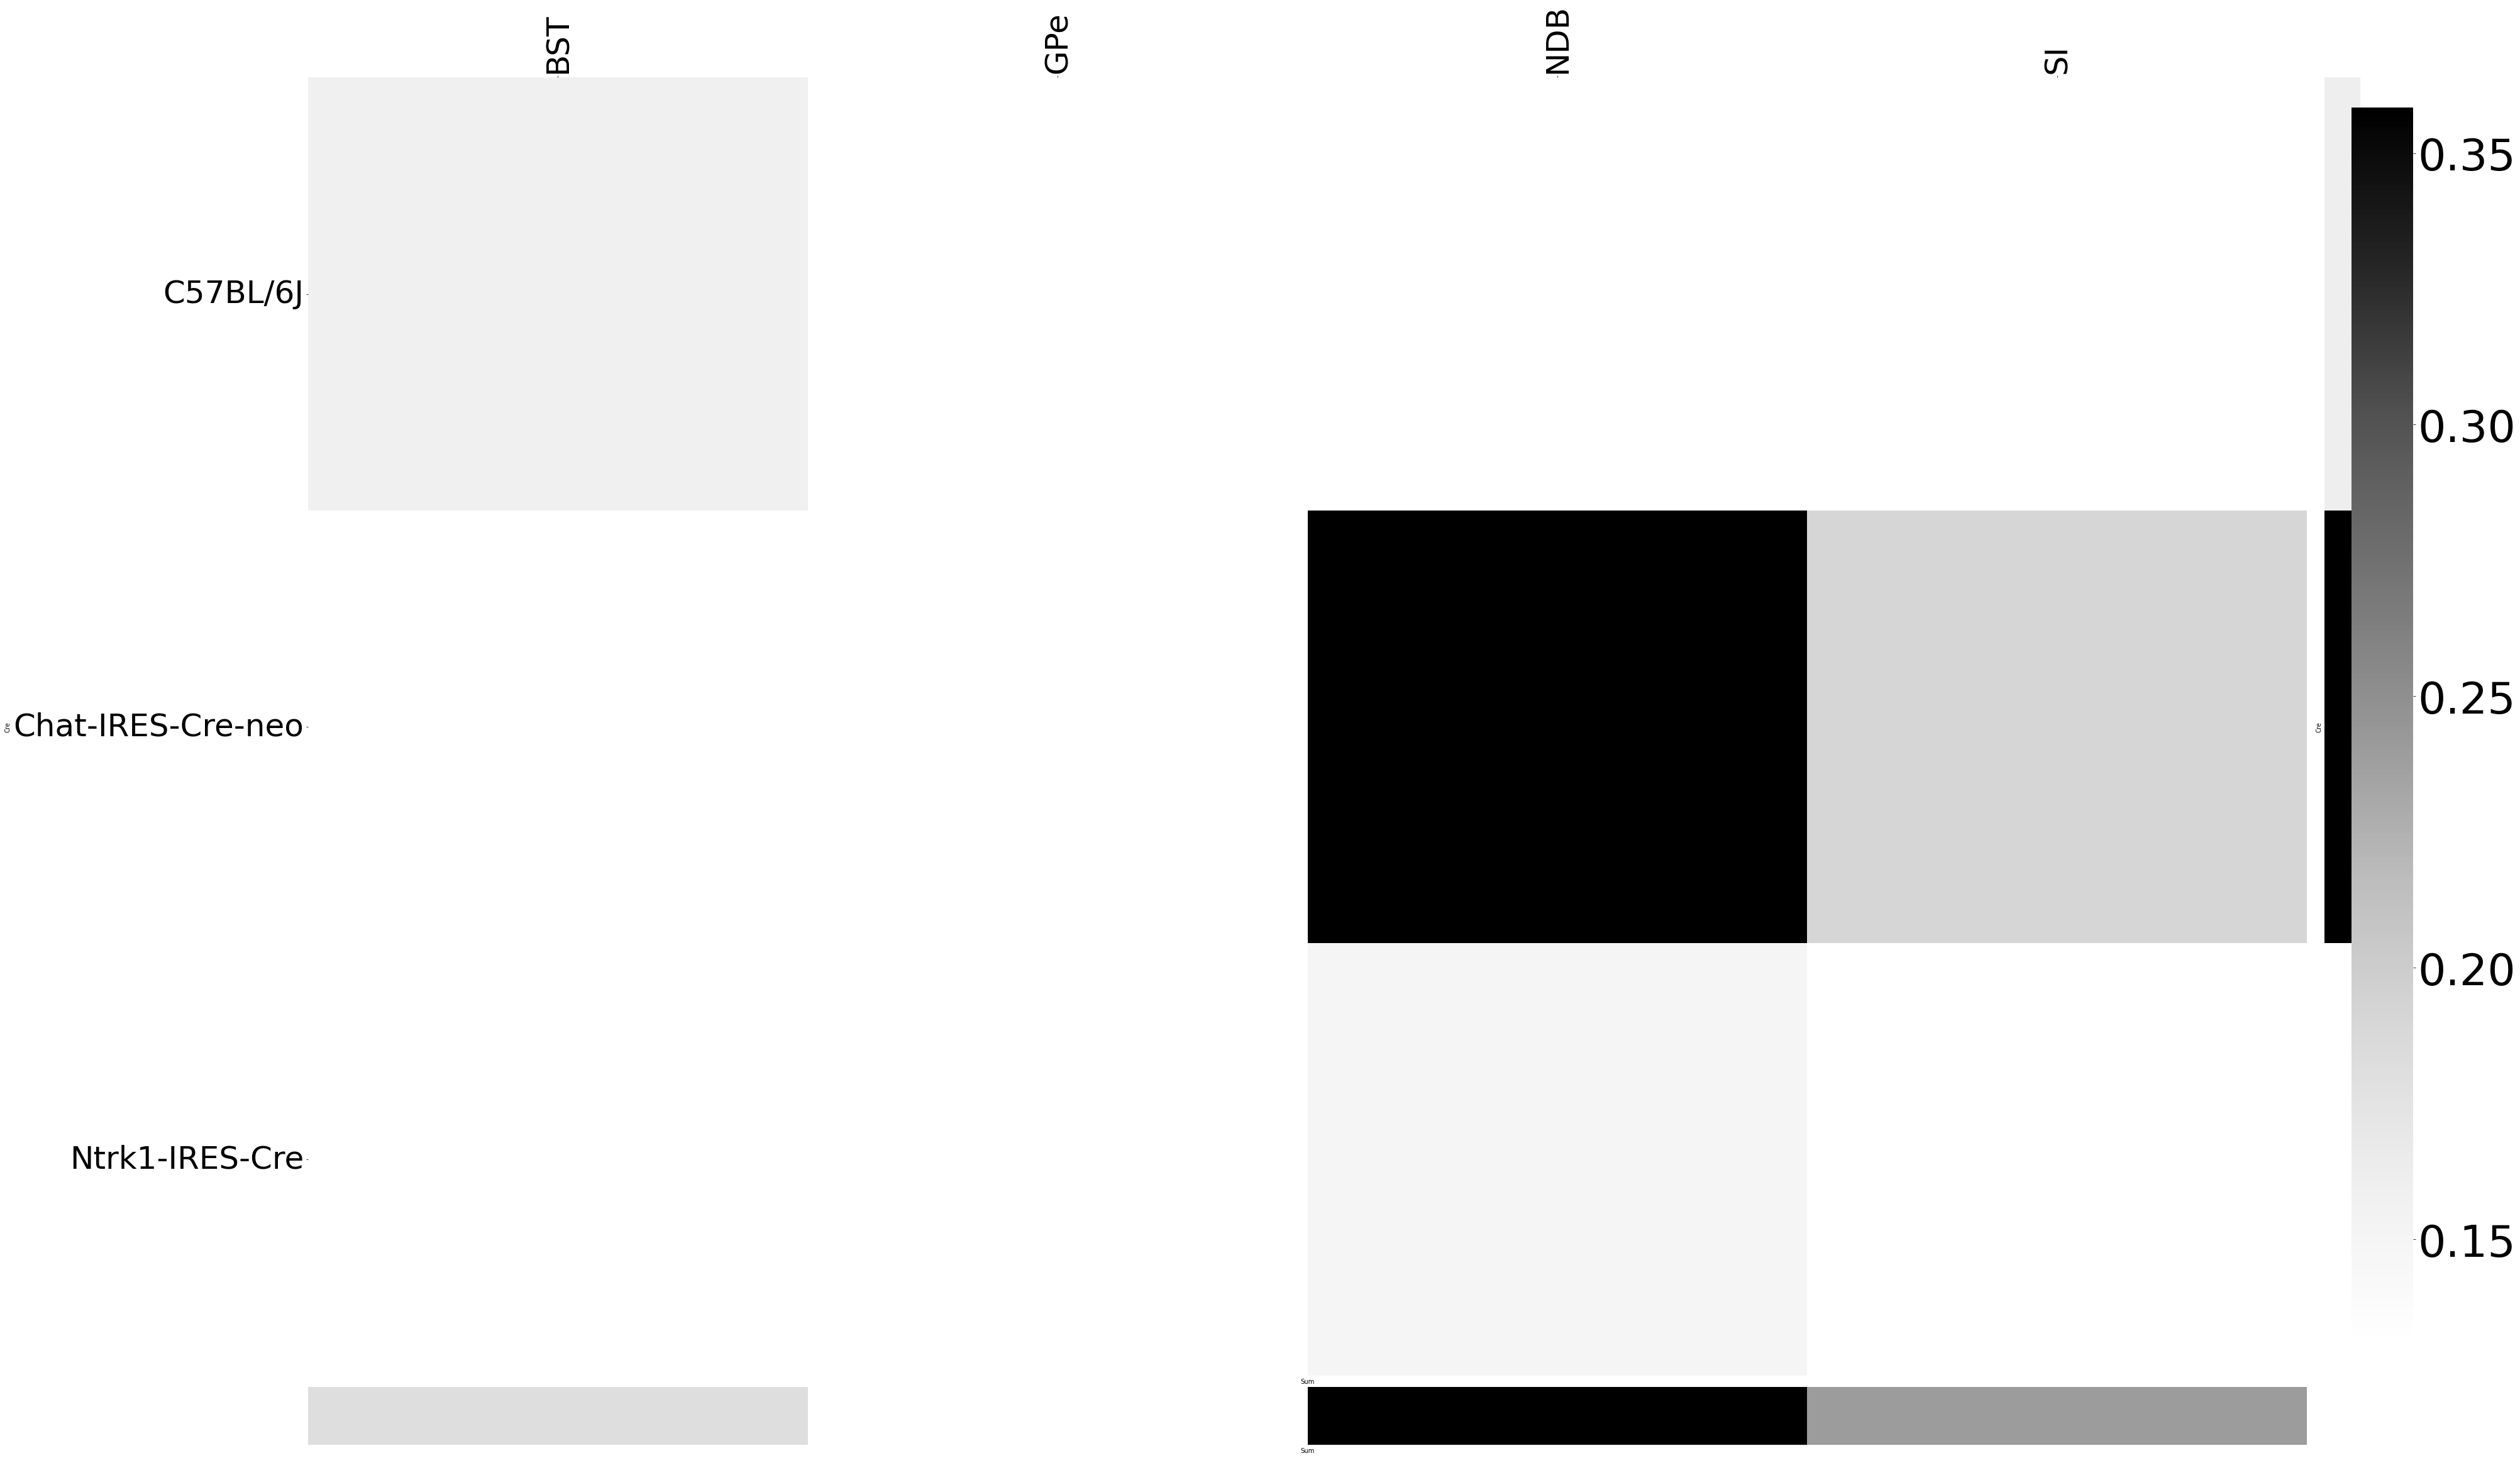

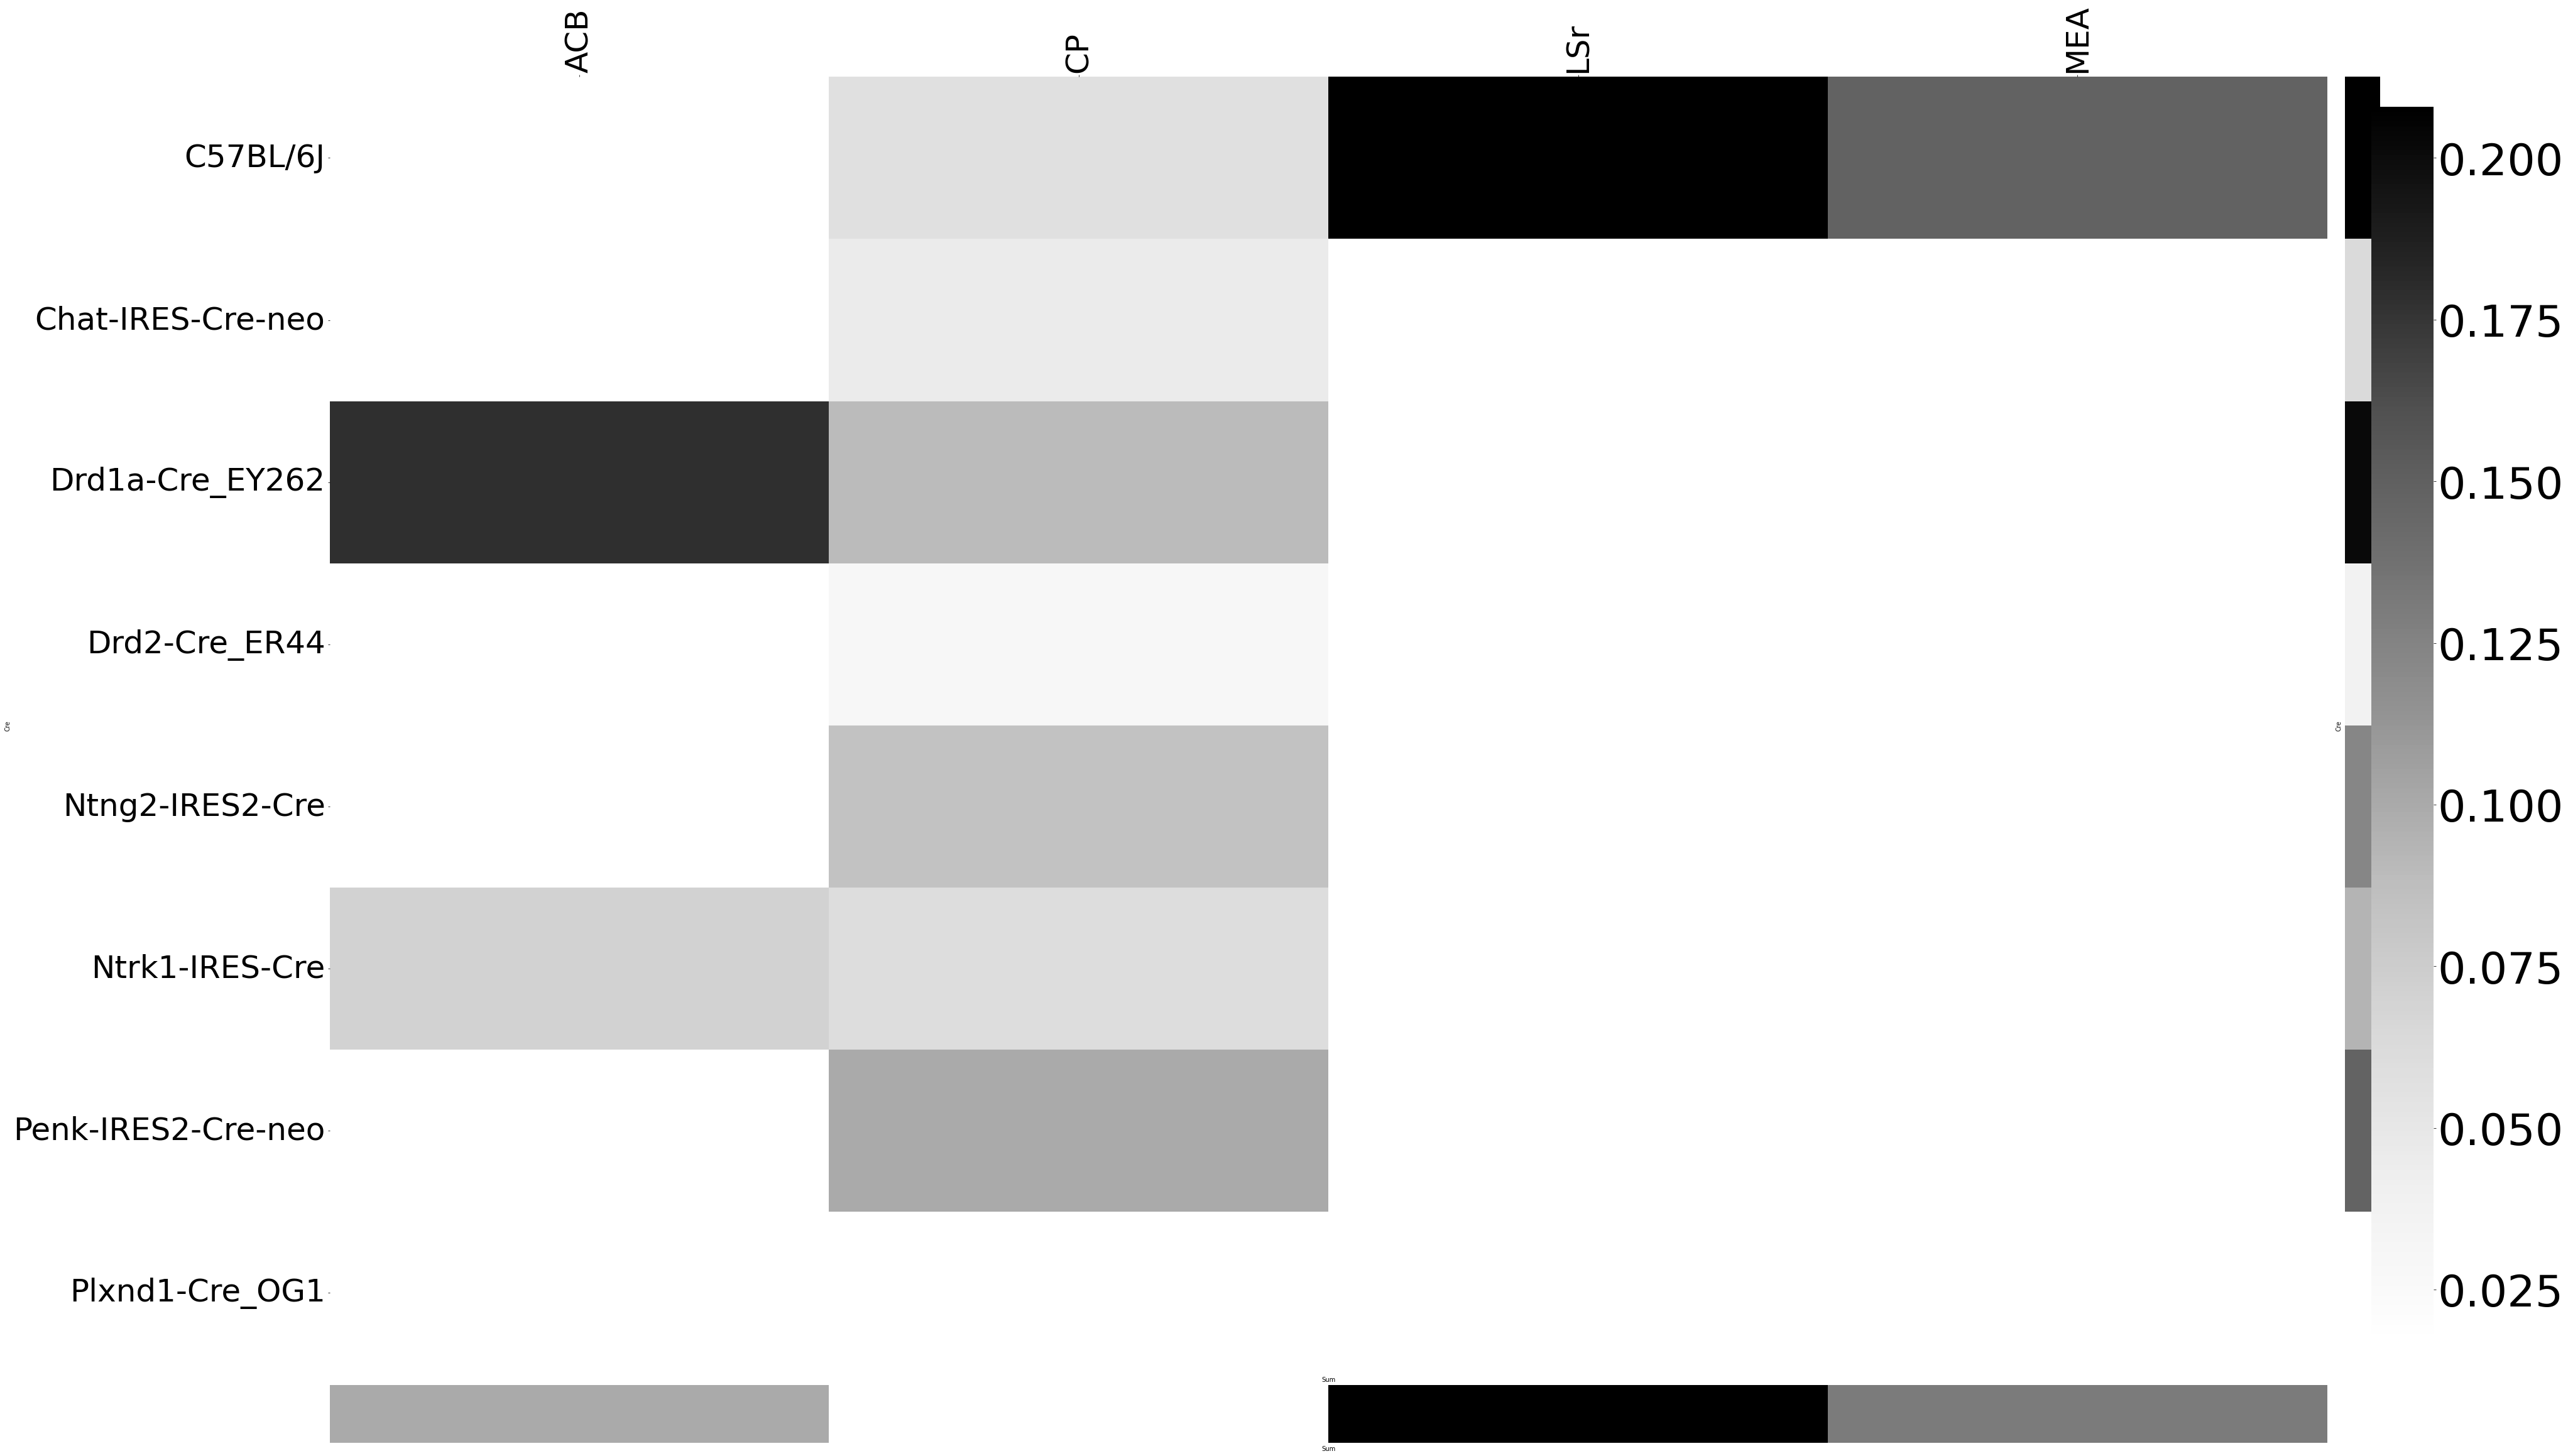

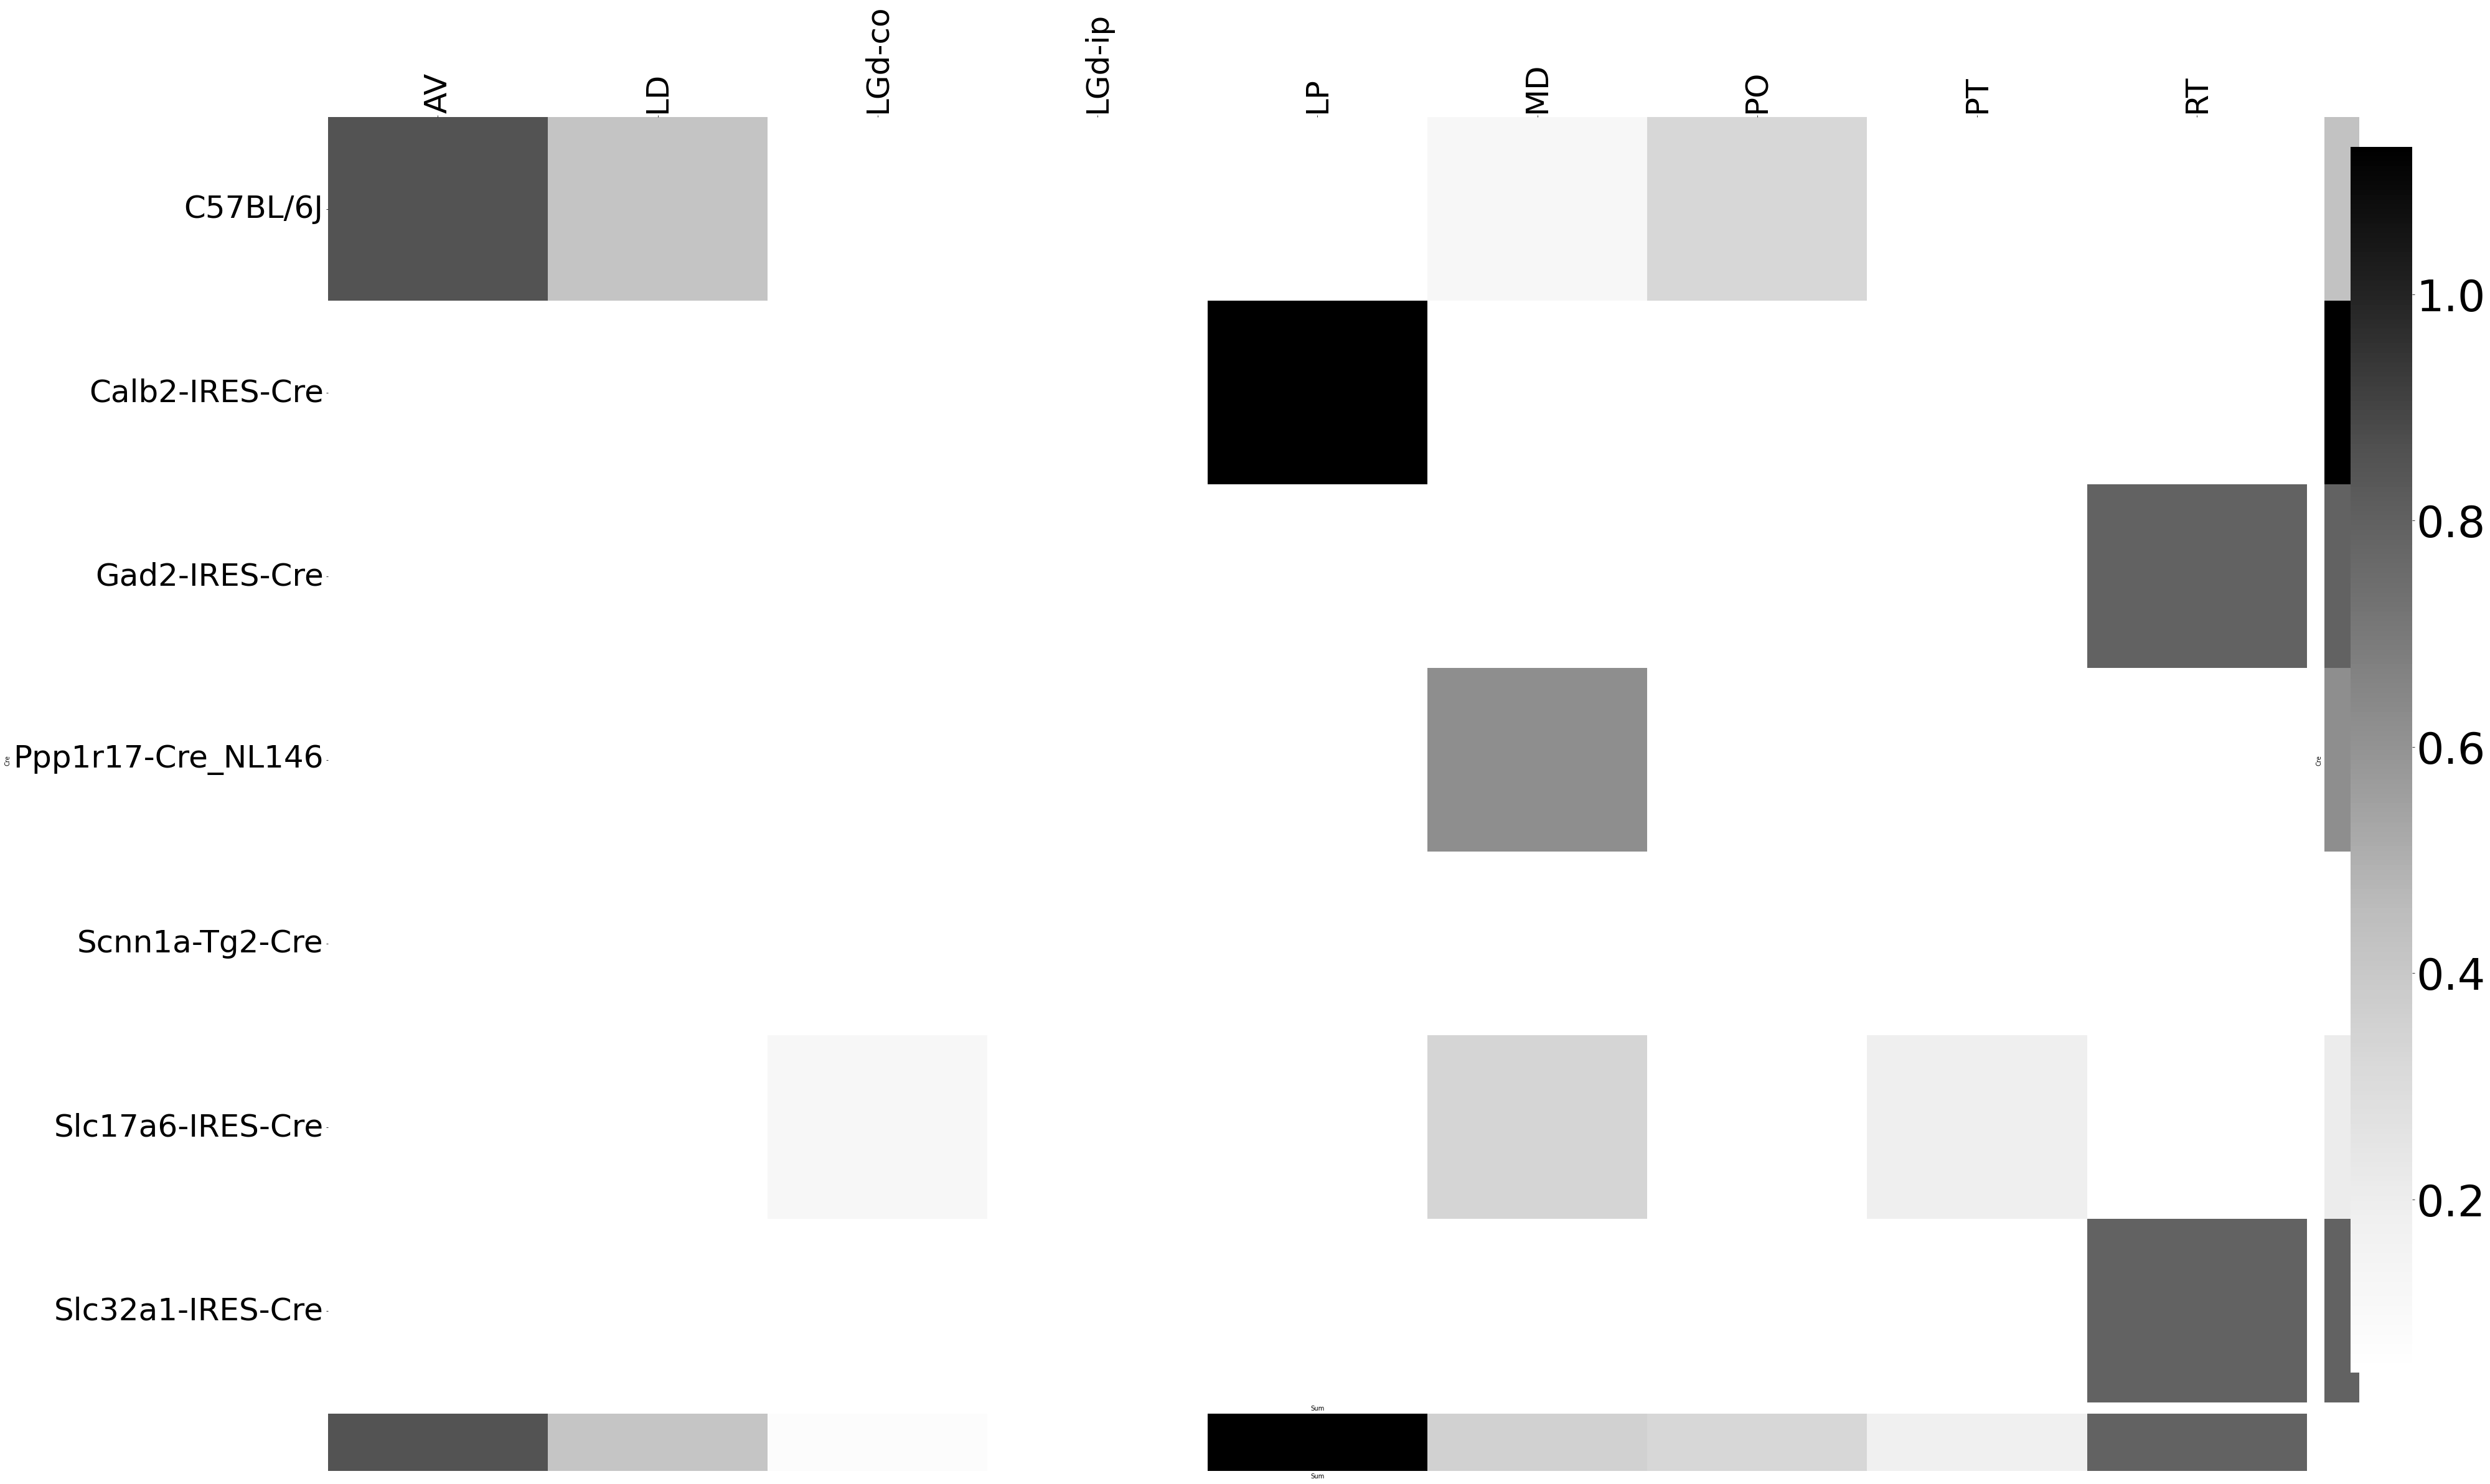

In [98]:
for sid in major_structure_ids:
    fig = plot_loss(twostage_leaf_creleaf2.weighted_losses[sid], fontsizes[sid])
    fig.savefig('paper/KoelleConn_fromlocal_0623/figs/lossdetails_' + str(sid), pad_inches = 0)
    #fig.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/figures/lossdetails_0618_' + str(sid), pad_inches = 0)

/Users/samsonkoelle/mouse_connectivity_models/mcmodels/core/plotting.py:17: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/Users/samsonkoelle/mouse_connectivity_models/mcmodels/core/plotting.py:31: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


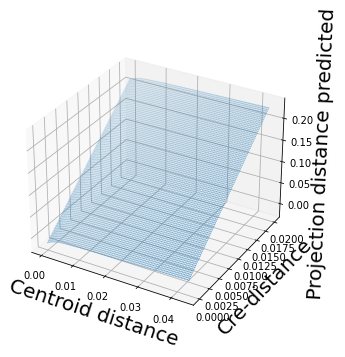

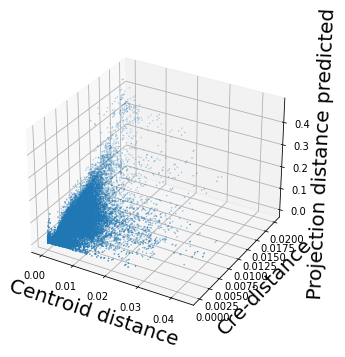

In [83]:
#%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv_leaf)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')
plot_loss_scatter(connectivity_data.structure_datas[315].loss_surface_cv_leaf)
#plt.scatter(np.log10(twostage_leaf_creleaf2.predictions[315][5][0]), np.log10(connectivity_data.structure_datas[315].reg_proj_norm[0]))

In [84]:
twostage_leaf_creleaf2.predictions[315][5][0].shape, connectivity_data.structure_datas[315].reg_proj_norm[0].shape

((1123,), (1123,))

In [85]:
gammaids = np.zeros(12)
for m in range(12):
    gammaids[m] = np.where(gammas == twostage_leaf_creleaf2.bestgamma_weighted[m])[0]
gammaids = np.asarray(gammaids , dtype = int)

self = twostage_leaf_creleaf2
threshes = np.asarray([0,1e-9,1e-8,1e-7,1e-6,1e-5, 1e-4, 1e-3,1e-2])
sel_gammas = twostage_leaf_creleaf2.bestgamma_weighted

models = self.models
nmodels = len(models)
predictions = self.predictions
data = self.data
nt = len(threshes)
eval_indices = self.eval_indices
results_n1 = np.zeros((nmodels,nt))
results_p1 = np.zeros((nmodels,nt))
bestfpfn = np.zeros(nmodels)
npts = np.zeros(nmodels)
#fpfn_proportion = np.zeros((nmodels,nt))
for m in range(nmodels):
    sid = models[m]
    inds = eval_indices[sid]
    npt = len(eval_indices[sid])
    npts[m] = npt
#     aboves[sid] = np.zeros((nt, npt))
#     belows[sid] = np.zeros((nt, npt))
#     w_ab[sid] = np.zeros((nt, npt))
#     w_be[sid] = np.zeros((nt, npt))
    
    #results_p1 = np.zeros(nt)
    for c in range(nt):
        output = np.ones(data[sid][inds].shape)
        baseline = np.ones(data[sid][inds].shape)
        #pred_mat = loocvpredictions[315][5].copy()
        zeroind_data = np.asarray(np.where(data[sid][inds] == 0.))
        zeroind_pred = np.asarray(np.where(predictions[sid][gammaids[m]][inds]  <= threshes[c]))
        output[tuple(zeroind_pred)] = 0.
        baseline[tuple(zeroind_data)] = 0.
        diff = output - baseline
        # results_p1 is how many false positives
        # results_n1 is how many false negatives
        results_n1[m,c] = np.where(diff == -1)[0].shape[0]
        results_p1[m,c] = np.where(diff == 1)[0].shape[0]
    
    bestfpfn[m] = np.abs(results_p1[m] - results_n1[m]).argmin()
    
fpfn_proportion = np.abs(results_p1 - results_n1) / (np.expand_dims(npts,1)*data[512].shape[1])
fpfn_proportion= pd.DataFrame(fpfn_proportion, columns=threshes, index=major_structures)
combpos = fpfn_proportion + fpfn_proportion
    #return(fpfn_proportion)
    #return(results_n1)

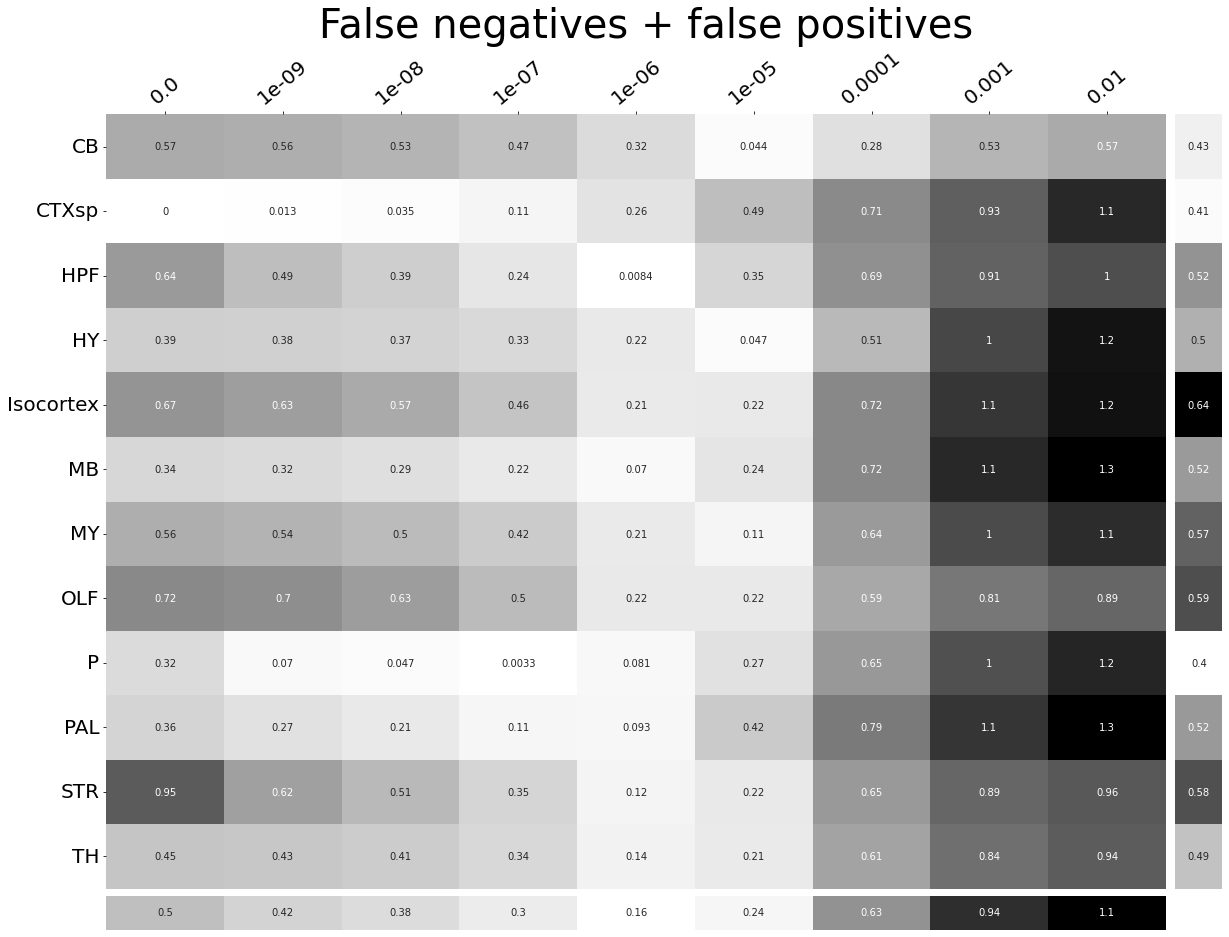

In [90]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)
#ax4 = plt.subplot2grid((20,20), (19,19), colspan=19, rowspan=1)
#ax4.set_title('asdf')
#ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)
#mask = np.zeros_like(combpos)
#mask[np.tril_indices_from(mask)] = True

sns.heatmap(combpos, ax = ax1, annot=True, cmap="Greys", linecolor='b', cbar = False)
#ax1.set_title("Threshold", fontsize = 15)
#ax1.ax_cbar.set_position([1.0,0.4,.1,.1])
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize = 20)
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize = 20, rotation = 0)
#ax1.set_xlabel('Threshold')
ax1.xaxis.tick_top()
ax1.set_xticklabels(combpos.columns,rotation=40)

sns.heatmap((pd.DataFrame(combpos.mean(axis=0))).transpose(), ax=ax2,  annot=True, cmap="Greys", cbar=False, xticklabels=False, yticklabels=False)
sns.heatmap(pd.DataFrame(combpos.mean(axis=1)), ax=ax3,  annot=True, cmap="Greys", cbar = False,
            xticklabels=False, yticklabels=False)


plt.suptitle('False negatives + false positives', fontsize = 40)
fig.savefig('paper/KoelleConn_fromlocal_0623/figs/Threshold', pad_inches = 0)

In [ ]:
surfaces = {}
for m in range(len(major_structure_ids)):
    sid = major_structure_ids[m]
    surfaces[sid ] = connectivity_data.structure_datas[sid].loss_surface_cv_sum
    surfaces[sid ].gamma = twostage_sum_creleaf2.bestgamma_weighted[m]
    
with open('paper/KoelleConn_fromlocal_0623/figs/ELleaf_surface_0427_leafleaf2.pickle', 'wb') as handle:
    pickle.dump(surfaces, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
major_structures

array(['CB', 'CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'MY', 'OLF', 'P',
       'PAL', 'STR', 'TH'], dtype='<U9')

In [94]:
major_structure_ids

array([ 512,  703, 1089, 1097,  315,  313,  354,  698,  771,  803,  477,
        549])